# **Algoritmo de ML para Credit Score**

In [ ]:
# Instalar la libreria PyCaret para el modelamiento y gspread para cargar la base de datos
!pip install pycaret

!pip install gspread

Importamos las librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
# Paleta de colores a utilizar para los graficos
palette = sns.color_palette(['#70ad47', '#5fb2aa', '#367482', '#33d9bb', '#4b2685', '#b6a5ca'])

# Preparación  de base de datos para modelar

Hacemos uso de gspread para leer la base de datos del archivo gsheet

In [ ]:
#Importamos las librerías para realizar la autenticacion con Google Drive
from google.colab import auth
auth.authenticate_user()

import gspread

In [ ]:
# Importamos libreria para cargar la base de datos sin credenciales
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
#Importar la hoja de calculo

# Acceder a una hoja específica
worksheet = spreadsheet.worksheet('Sheet1')

# Realizar operaciones en la hoja de cálculo, como leer o escribir datos
db = worksheet.get_all_values()

#Guardar los datos en un DataFrame
data = pd.DataFrame(db)

# Asignar los valores de la primera fila como encabezados de columna
data.columns = data.iloc[0]

# Eliminar la primera fila de los datos
data = data[1:]

In [ ]:
data.head()

,Nombre,Emprendimiento,Código del Emprendimiento,Target,Días Máximos en Mora,Capacidad de Pago,Sector,¿Cuál es el giro de tu emprendimiento?,¿En qué fase se encuentra el emprendimiento?,¿Cuánto son tus ventas promedio mensuales? (Últimos 3 meses),...,"Entre las siguientes palabras, ¿con cuál te identificas más?.2","Entre las siguientes palabras, ¿con cuál te identificas más?.3",Explícanos el problema/necesidad/deseo que tu emprendimiento quiere resolver para tus potenciales clientes.,Explícanos la solución que tu emprendimiento ofrece al problema/necesidad/deseo identificado. ¿Cuáles son los productos o servicios que ofreces? ¿Cómo haces llegar tu solución a tus clientes?,¿Cuáles son las características de tu segmento de clientes?,¿Qué te hace diferente a tus competidores? ¿Cuáles son tus fortalezas y debilidades?,¿Cuál es tu propuesta de valor? ¿Qué beneficios le entregas a tus clientes?,¿Cuáles son tus metas a largo plazo?,¿Cómo ves tu emprendimiento en el futuro?,¿Qué riesgos temes correr con tu emprendimiento?
1,Tatiana Dalence,A granel,403,1,1,,Alimentos y/o bebidas,Producción,Tengo un segmento abundante de clientes,Entre Bs 3.501 a Bs 7.000,...,Investigadora,Encantadora,,,,,,,,
2,Sheila Norka de Alencar Villarroel,Agua joyas,432,0,17,2550,Aplicaciones Móviles,Producción,Tengo un segmento abundante de clientes,Entre Bs 3.501 a Bs 7.000,...,Investigadora,Confiable,2,3,2,1,1,3,3,1
3,Camila Requena,Allegra adonai,399,0,7,3030,Comercio y compras,Comercial,Tengo un segmento abundante de clientes,Entre Bs 3.501 a Bs 7.000,...,Ingeniosa,Encantadora,2,2,1,2,2,1,1,2
4,Camila Requena,Allegra adonai,399,0,23,3030,Arte y cultura,Comercial,Tengo un segmento abundante de clientes,Entre Bs 3.501 a Bs 7.000,...,Arriesgada,Confiable,2,2,1,2,2,1,1,2
5,Yaneth melgar vargas,Artesanías la reina,,0,334,,Arte y cultura,Producción,Mi negocio está listo para expandirse,Entre Bs 3.501 a Bs 7.000,...,Arriesgada,Discreta,2,2,2,2,2,1,2,1


Preparamos la base de datos para el modelamiento

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 1 to 81
Data columns (total 41 columns):
 #   Column                                                                                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                                                                                           --------------  ----- 
 0   Nombre                                                                                                                                                                                           81 non-null     object
 1   Emprendimiento                                                                                                                                                                                   81 non-null     object
 2   Código d

In [ ]:
#Revisar las ultimas filas para controlar que los datos cargados sean los correctos
data.tail()

In [ ]:
# Detectar registros vacios al realizar la lectura de la hoja de calculo
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [ ]:
# Descartar las columnas que no se van a utilizar
columnas_irrelevantes=['Nombre', 'Emprendimiento', 'Código del Emprendimiento']
data=data.drop(columnas_irrelevantes, axis=1)

In [ ]:
# Función para eliminar los acentos de un string
def normalize(string):
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u")
      )
  for a, b in replacements:
      string = string.lower().replace(a, b)
  return string

In [ ]:
#Renombramos las columnas para eliminar los acentos
data = data.rename(columns=normalize)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 1 to 81
Data columns (total 38 columns):
 #   Column                                                                                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                                                                                           --------------  ----- 
 0   target                                                                                                                                                                                           81 non-null     object
 1   dias maximos en mora                                                                                                                                                                             81 non-null     object
 2   capacida

In [ ]:
# Rellenar los valores faltantes en variables categoricas por la moda
columns=data.iloc[:,30:].columns

for column in columns:
  data[column]=data[column].fillna(data[column].dropna().mode().values[0])

In [ ]:
#Eliminar la columna Capacidad de pago por la cantidad de valores faltantes
data=data.drop('capacidad de pago', axis=1)

In [ ]:
# Cambiar el tipo de dato de las variables numericas
data['¿cuantos hijos tienes?']=data['¿cuantos hijos tienes?'].astype(int)
data['dias maximos en mora']=data['dias maximos en mora'].astype(int)
data['target']=data['target'].astype(int)

<ipython-input-19-2d28d31e1343>:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='target', y='dias maximos en mora', data=data, jitter=True, palette=palette)
<ipython-input-19-2d28d31e1343>:4: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.stripplot(x='target', y='dias maximos en mora', data=data, jitter=True, palette=palette)


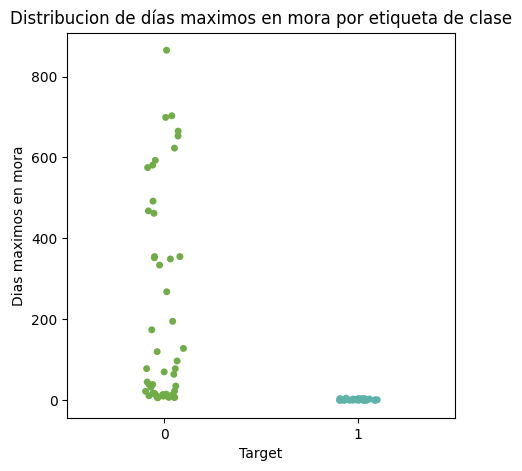

In [ ]:
# Grafico de puntos para ver la relacion entre dias max de mora y target
plt.figure(figsize=(5,5))

sns.stripplot(x='target', y='dias maximos en mora', data=data, jitter=True, palette=palette)

plt.title('Distribucion de días maximos en mora por etiqueta de clase')
plt.xlabel('Target')
plt.ylabel('Dias maximos en mora')
plt.show()

In [ ]:
#Eliminar la columna dias maximos en mora
data=data.drop('dias maximos en mora', axis=1)

Como ultimo paso se revisa el desbalance de la variable a predecir

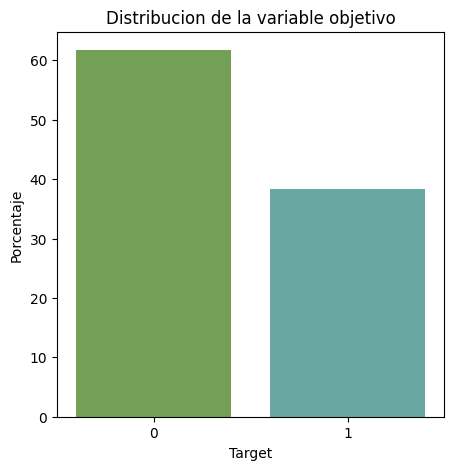

In [ ]:
# Graficar la cantidad de registros por etiqueta de la variable Target
plt.figure(figsize=(5,5))

target_porcentaje=data['target'].value_counts(normalize=True)*100
sns.barplot(x = target_porcentaje.index, y= target_porcentaje, palette=palette)

plt.xlabel('Target')
plt.ylabel('Porcentaje')
plt.title('Distribucion de la variable objetivo')
plt.show()

Se puede observar claramente que la variable objetivo presenta un desbalance significativo. La clase "0" (malos pagadores) representa aproximadamente el 65% del total de registros, mientras que la clase "1" (buenos pagadores) solo representa alrededor del 35%.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 1 to 81
Data columns (total 36 columns):
 #   Column                                                                                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                                                                                           --------------  ----- 
 0   target                                                                                                                                                                                           81 non-null     int64 
 1   sector                                                                                                                                                                                           81 non-null     object
 2   ¿cual es

Observaciones:

1. Hay valores faltantes en las columnas `Capacidad de Pago` y las preguntas abiertas (ultimas 8 columnas), para estas ultimas completamos con la moda, siendo lo mas recomendable para variables categoricas. Como solo se tienen 25 registros completos de un total de 81 en capacidad de pago, se considera que no hay suficientes datos para relacionar esta variable con otras y determinar algún patrón significativo que permita imputar los faltantes. Por lo tanto, se decide eliminar esta variable del conjunto de datos.

2. La variable `Dias maximos en mora` está fuertemente relacionada con la variable a predecir `target`. Se observa que las etiquetas con valor 1 corresponden a registros con bajos días de mora, mientras que los registros con mayor cantidad de días de mora se marcan con 0, indicando ser malos pagadores. Esta relación estrecha podría sesgar el modelo, haciéndolo depender excesivamente de esta variable y no capturar otras características importantes que influyeran en la predicción del objetivo. Para abordar el problema, se probó el modelo "Decision Tree" y se confirmó que estaba sesgado por la variable "Días máximos en mora". Por lo tanto, se decidió **descartar esta variable** y probar varios modelos sin considerarla para mejorar la precisión y generalización del modelo.

# Comparación de tecnicas de `feature selection`

 Para evaluar distintos metodos de seleccion de caracteristicas se utiliza la libreria `pyCaret` que permite comparar distintos modelos de clasificacion segun la metrica seleccionada. Esta libreria cuenta con 3 metodos de seleccion de caracteristicas diferentes:

 1. `Univariate`: Basado en el método de filtrado, selecciona las mejores características en función de  “ANOVA f-test”, una prueba de hipótesis estadística paramétrica para determinar si las medias entre cada característica individual y la variable objetivo provienen de la misma distribución o no.

 2. `Sequential`: Basado en el método "wrapper" (de envoltura) que utiliza algoritmo de búsqueda Sequential Forward Selection (SFS). El procedimiento se detiene cuando se alcanza el número deseado de características seleccionadas, según lo determinado por el parámetro **n_features_to_select** al configurar el modelo.

 3. `Classic`: Se basa también en el método "wrapper" y además en el uso de un modelo de aprendizaje automático en sí. Consiste en tomar todas las características y se eliminan si la importancia correspondiente de los valores de las funciones está por debajo del parámetro “threshold” proporcionado

In [ ]:
# Importar los modelos de clasificacion
import pycaret
from pycaret.classification import *

In [ ]:
#lista de modelos sobre los que se va a realizar la comparacion
models_list = ['lr', 'knn',  'nb', 'dt', 'svm',  'rbfsvm', 'gpc', 'mlp', 'rf', 'gbc', 'xgboost']

In [ ]:
#Configurar el modelo con el metodo univariado
model_setup=setup(data, target='target', session_id=42, train_size= 0.75 , fold= 4,
                  feature_selection = True, feature_selection_method = 'univariate',
                  n_features_to_select= 0.4, normalize= True, remove_multicollinearity=True, verbose= False)

#Comparar los modelos con sus metricas
best_models_univariate=compare_models(sort='F1', include= models_list, n_select= len(models_list))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7462,0.4917,0.6012,0.5069,0.3010,0.3173,3.1125
rbfsvm,SVM - Radial Kernel,0.6667,0.6677,0.4500,0.6429,0.4917,0.2662,0.2998,0.8575
mlp,MLP Classifier,0.6667,0.7220,0.4083,0.6012,0.4514,0.2505,0.2742,2.2850
gpc,Gaussian Process Classifier,0.6500,0.5342,0.4083,0.5595,0.4403,0.2193,0.2369,0.9875
lr,Logistic Regression,0.6333,0.7656,0.4083,0.5179,0.4292,0.1881,0.1997,5.0875
rf,Random Forest Classifier,0.6167,0.6634,0.3583,0.4833,0.4056,0.1437,0.1445,1.2950
svm,SVM - Linear Kernel,0.6167,0.0000,0.3583,0.5238,0.3986,0.1511,0.1661,0.9200
nb,Naive Bayes,0.6333,0.7560,0.4917,0.5000,0.3919,0.2068,0.2784,0.8750
xgboost,Extreme Gradient Boosting,0.5667,0.6306,0.3083,0.4464,0.3547,0.0440,0.0498,0.8850
dt,Decision Tree Classifier,0.5833,0.5744,0.2583,0.4000,0.3100,0.0411,0.0381,1.2175


Processing:   0%|          | 0/59 [00:00<?, ?it/s]

In [ ]:
#Configurar el modelo con el metodo secuencial
model_setup=setup(data, target='target', session_id=42, train_size= 0.75 , fold= 4,
                  feature_selection = True, feature_selection_method = 'sequential',
                  n_features_to_select= 0.4, normalize= True, remove_multicollinearity=True, verbose= False)

#Comparar los modelos con sus metricas
best_models_sequential=compare_models(sort='F1', include= models_list, n_select= len(models_list))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.4167,0.5301,0.9083,0.3866,0.5421,0.0111,0.0345,1.3425
rf,Random Forest Classifier,0.6833,0.6192,0.4667,0.6054,0.5116,0.2849,0.2964,1.9325
knn,K Neighbors Classifier,0.5333,0.5610,0.5667,0.4861,0.4966,0.1147,0.0888,1.1675
mlp,MLP Classifier,0.6167,0.6283,0.4750,0.5111,0.4808,0.1791,0.1840,1.6750
dt,Decision Tree Classifier,0.6500,0.5627,0.4250,0.6111,0.4714,0.2208,0.2463,0.9025
gpc,Gaussian Process Classifier,0.6333,0.6431,0.4250,0.5179,0.4525,0.1834,0.1915,1.1575
xgboost,Extreme Gradient Boosting,0.6333,0.5667,0.3833,0.5250,0.4350,0.1737,0.1819,1.2200
gbc,Gradient Boosting Classifier,0.6000,0.5483,0.4250,0.4861,0.4298,0.1261,0.1349,1.0700
lr,Logistic Regression,0.5833,0.5523,0.3000,0.3571,0.3209,0.0579,0.0401,43.6400
rbfsvm,SVM - Radial Kernel,0.5667,0.5982,0.2167,0.3125,0.2431,-0.0013,-0.0195,1.0775


Processing:   0%|          | 0/59 [00:00<?, ?it/s]

In [ ]:
# Realizar una copia de la base de datos para descartar simbolos en los nombres de las columnas
data_= data.copy()
data_.columns=data_.columns.str.replace('[^a-zA-Z0-9_]', ' ', regex=True)

#Configuracion del modelo con el metodo clasico
model_setup=setup(data_, target='target', session_id=42, train_size= 0.75 , fold= 4,
                  feature_selection = True, n_features_to_select= 0.4, normalize= True,
                    remove_multicollinearity=True, verbose= False)
#Comparacion de los modelos con sus metricas
best_models_classic=compare_models(sort='F1', include= models_list, n_select= len(models_list))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.6890,0.4750,0.6083,0.5280,0.2953,0.3024,1.0525
nb,Naive Bayes,0.4167,0.5330,0.8333,0.3866,0.5148,0.0019,-0.0064,0.5600
gbc,Gradient Boosting Classifier,0.6333,0.6675,0.4750,0.5417,0.5000,0.2083,0.2134,1.7275
mlp,MLP Classifier,0.6167,0.6586,0.4333,0.5167,0.4560,0.1659,0.1759,0.6375
dt,Decision Tree Classifier,0.6000,0.5806,0.4333,0.4750,0.4449,0.1347,0.1386,0.5625
xgboost,Extreme Gradient Boosting,0.6167,0.6512,0.3500,0.5250,0.4072,0.1426,0.1528,0.5850
rbfsvm,SVM - Radial Kernel,0.7000,0.4310,0.3083,0.6042,0.4000,0.2800,0.3162,0.7725
gpc,Gaussian Process Classifier,0.6000,0.5153,0.3417,0.4750,0.3965,0.1060,0.1118,1.2200
rf,Random Forest Classifier,0.6167,0.5772,0.3083,0.5000,0.3806,0.1270,0.1329,0.7350
lr,Logistic Regression,0.5833,0.5884,0.3417,0.4208,0.3739,0.0690,0.0677,0.6500


Processing:   0%|          | 0/59 [00:00<?, ?it/s]

# Modelos experimentales (Arbol de decisión)

In [ ]:
#Importar los modelos de clasificacion

#!pip install pycaret
import pycaret
from pycaret.classification import *

In [ ]:
# Diccionario con los nombres de los modelos a utilizar
models={
    'lr': 'Logistic Regression',
    'knn': 'K-Nearest Neighbors',
    'nb': 'Naive Bayes',
    'dt':'Decision Tree',
    'svm': 'SVM- Linear Kernel',
    'rbfsvm':'SVM- Radial Kernel',
    'mlp':'Multi-Layer Perceptron',
    'rf':'Random Forest',
    'xgboost':'XG Boost'
}

In [ ]:
# Definir la lista de modelos sobre los que se va a iterar
models_list = ['lr', 'knn',  'nb', 'dt', 'svm', 'rbfsvm', 'mlp', 'rf', 'xgboost']

# Definir los metodos de selección de características a utilizar
feature_selection_methods = ['univariate', 'classic', 'sequential']

# Crear un DataFrame vacío para almacenar los resultados
Resultados= pd.DataFrame(columns=['Model', 'Feature Selection', 'Accuracy train','Accuracy test', 'F1-score train', 'F1-score test', 'Grid Search', 'Best Hyperparameters'])

CONFUSION MATRIX FOR MODEL "LOGISTIC REGRESSION" WITH METHOD "UNIVARIATE" 



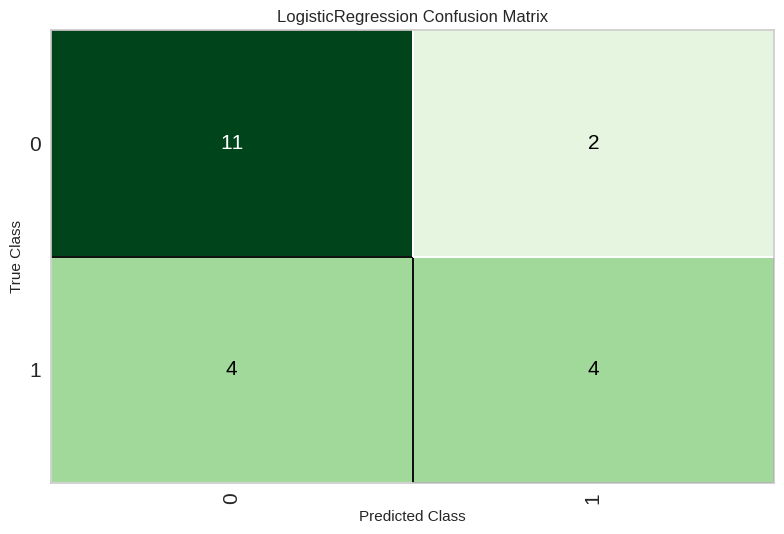


Accuracy train: 0.6333 
 Accuracy test: 0.7143 
 F1 score train: 0.4292 
 F1 score test: 0.5714
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "LOGISTIC REGRESSION" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



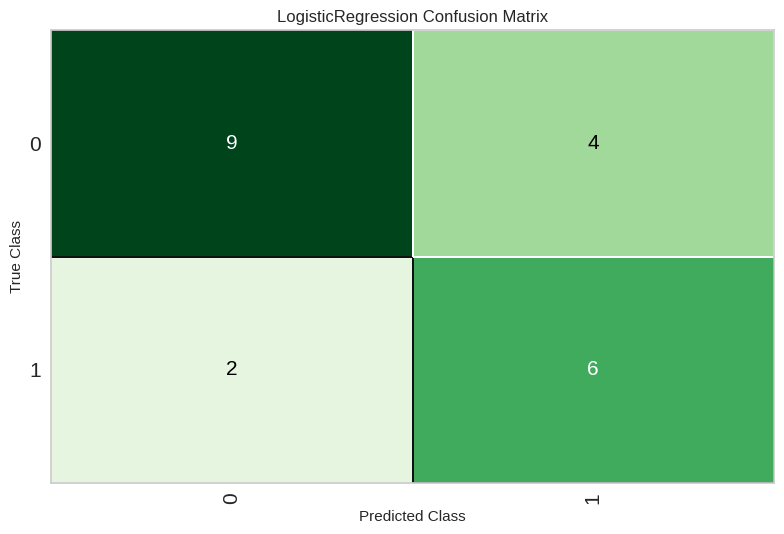


Accuracy train: 0.6833 
 Accuracy test: 0.7143 
 F1 score train: 0.553 
 F1 score test: 0.6667
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "K-NEAREST NEIGHBORS" WITH METHOD "UNIVARIATE" 



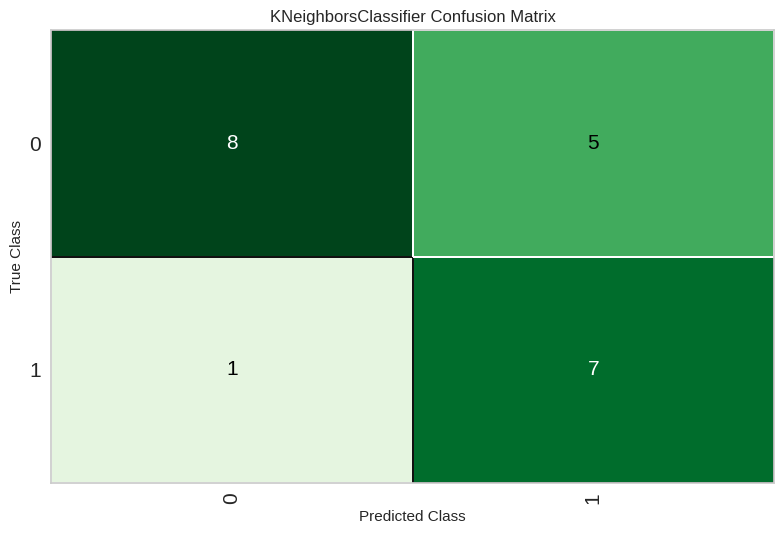


Accuracy train: 0.6833 
 Accuracy test: 0.7143 
 F1 score train: 0.5069 
 F1 score test: 0.7
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "K-NEAREST NEIGHBORS" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



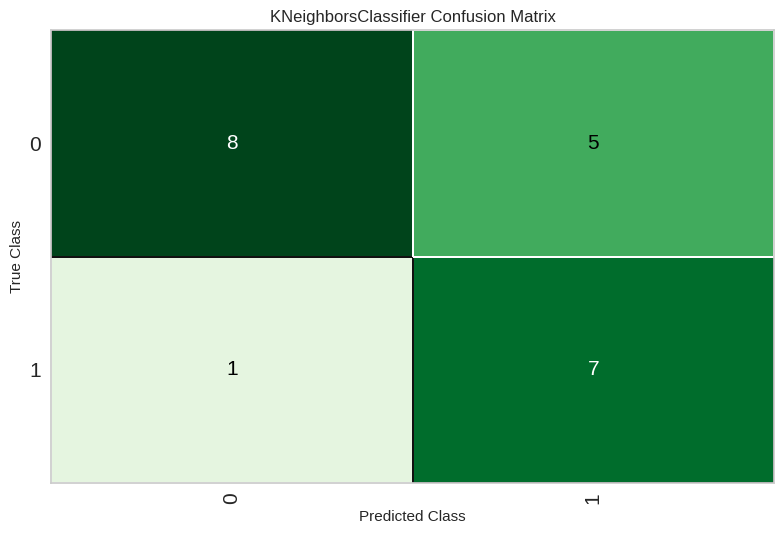


Accuracy train: 0.65 
 Accuracy test: 0.7143 
 F1 score train: 0.4708 
 F1 score test: 0.7
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "NAIVE BAYES" WITH METHOD "UNIVARIATE" 



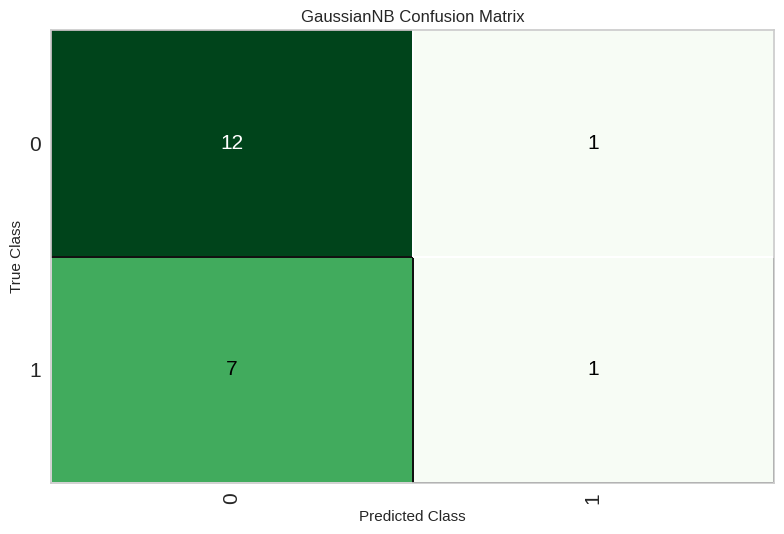


Accuracy train: 0.6333 
 Accuracy test: 0.619 
 F1 score train: 0.3919 
 F1 score test: 0.2
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "NAIVE BAYES" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



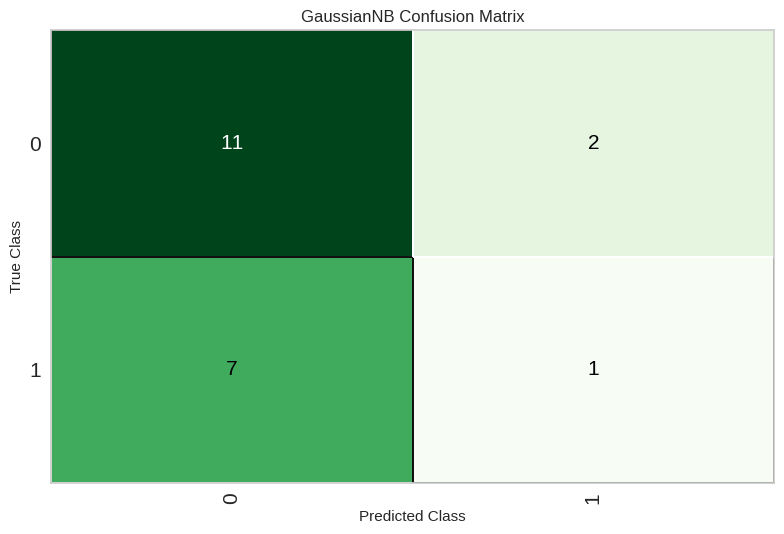


Accuracy train: 0.6667 
 Accuracy test: 0.5714 
 F1 score train: 0.4727 
 F1 score test: 0.1818
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "DECISION TREE" WITH METHOD "UNIVARIATE" 



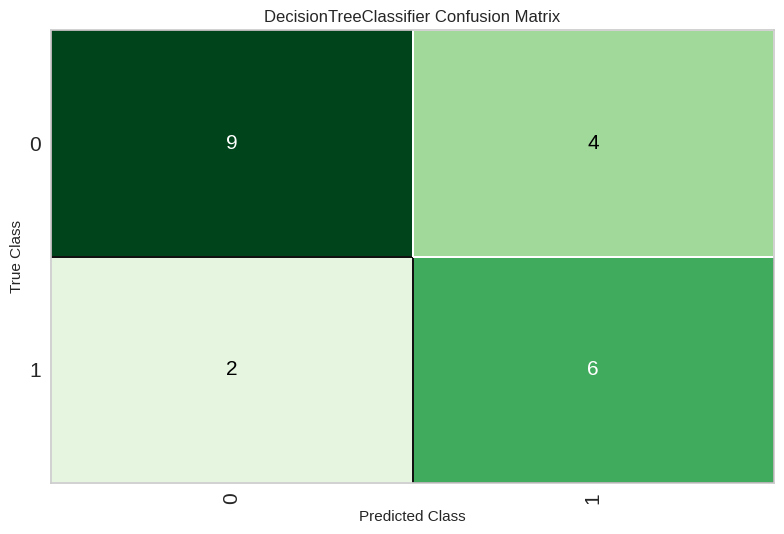


Accuracy train: 0.5833 
 Accuracy test: 0.7143 
 F1 score train: 0.31 
 F1 score test: 0.6667
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "DECISION TREE" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



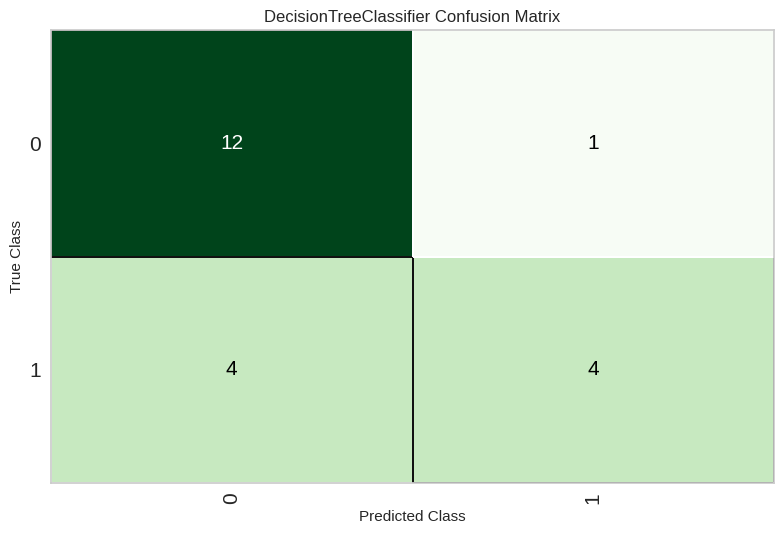


Accuracy train: 0.6167 
 Accuracy test: 0.7619 
 F1 score train: 0.4583 
 F1 score test: 0.6154
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "SVM- LINEAR KERNEL" WITH METHOD "UNIVARIATE" 



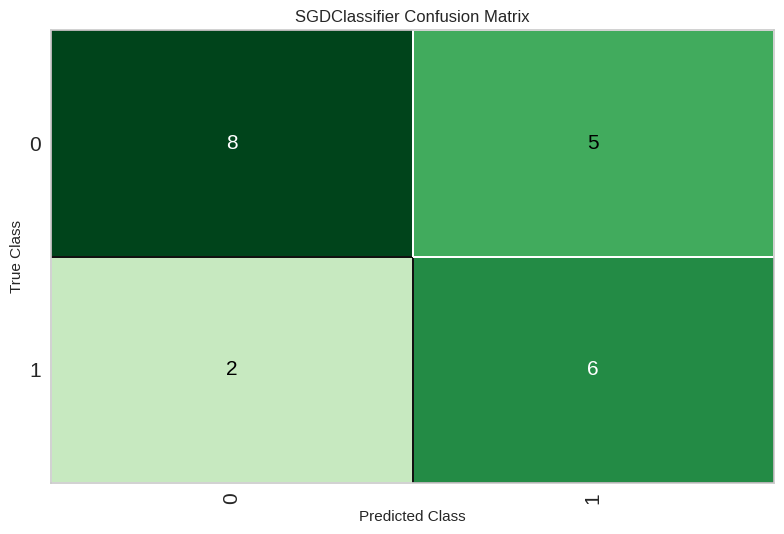


Accuracy train: 0.6167 
 Accuracy test: 0.6667 
 F1 score train: 0.3986 
 F1 score test: 0.6316
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "SVM- LINEAR KERNEL" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



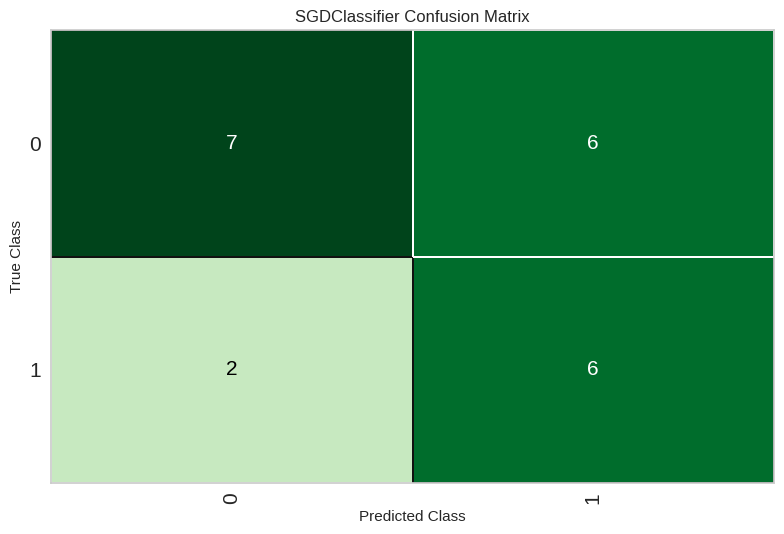


Accuracy train: 0.5833 
 Accuracy test: 0.619 
 F1 score train: 0.6009 
 F1 score test: 0.6
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "SVM- RADIAL KERNEL" WITH METHOD "UNIVARIATE" 



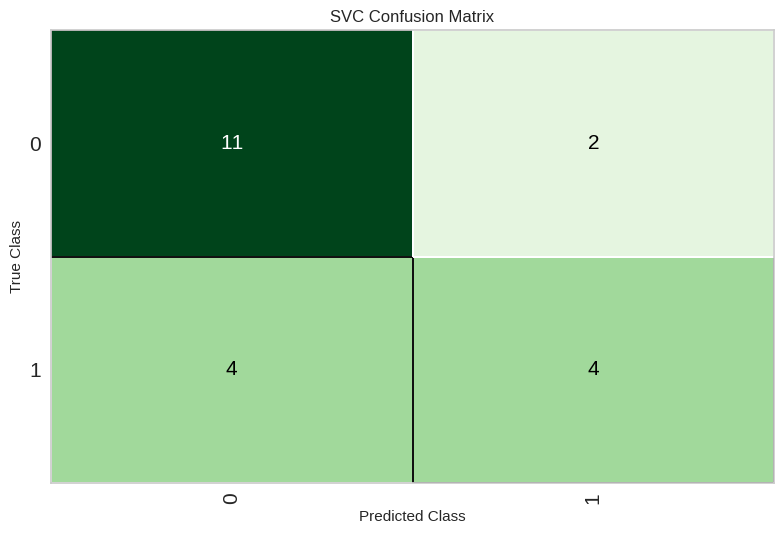


Accuracy train: 0.6667 
 Accuracy test: 0.7143 
 F1 score train: 0.4917 
 F1 score test: 0.5714
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "SVM- RADIAL KERNEL" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



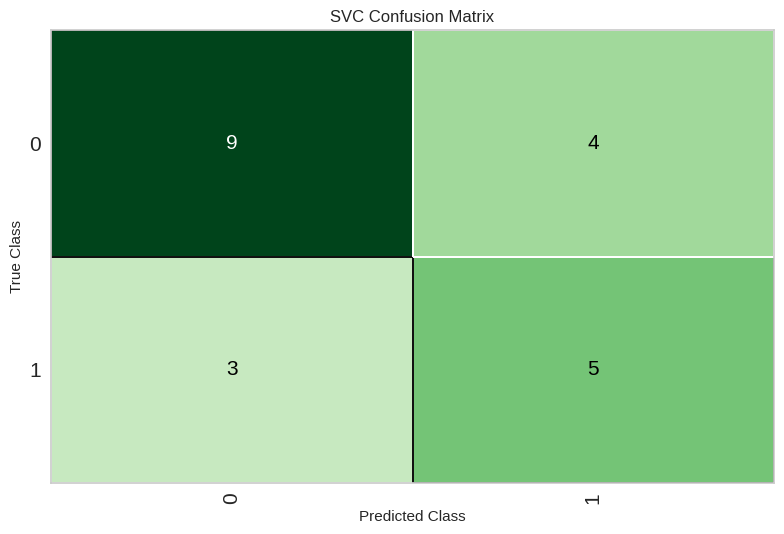


Accuracy train: 0.65 
 Accuracy test: 0.6667 
 F1 score train: 0.5205 
 F1 score test: 0.5882
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "MULTI-LAYER PERCEPTRON" WITH METHOD "UNIVARIATE" 



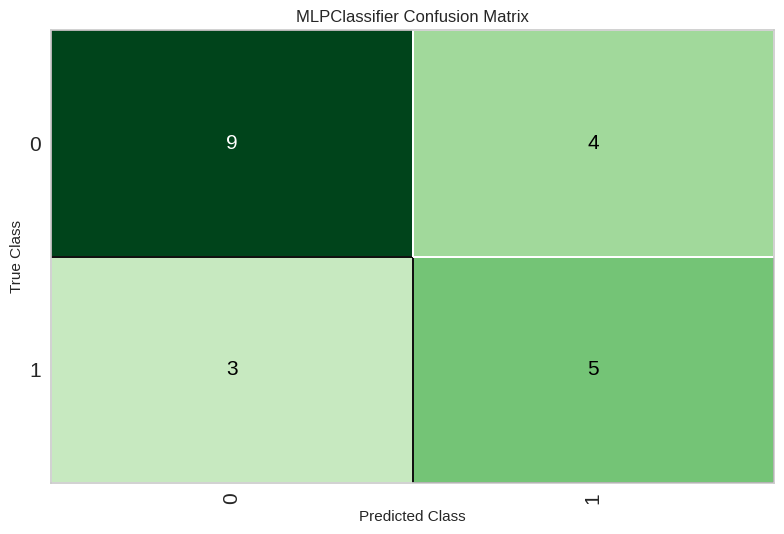


Accuracy train: 0.6667 
 Accuracy test: 0.6667 
 F1 score train: 0.4514 
 F1 score test: 0.5882
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "MULTI-LAYER PERCEPTRON" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



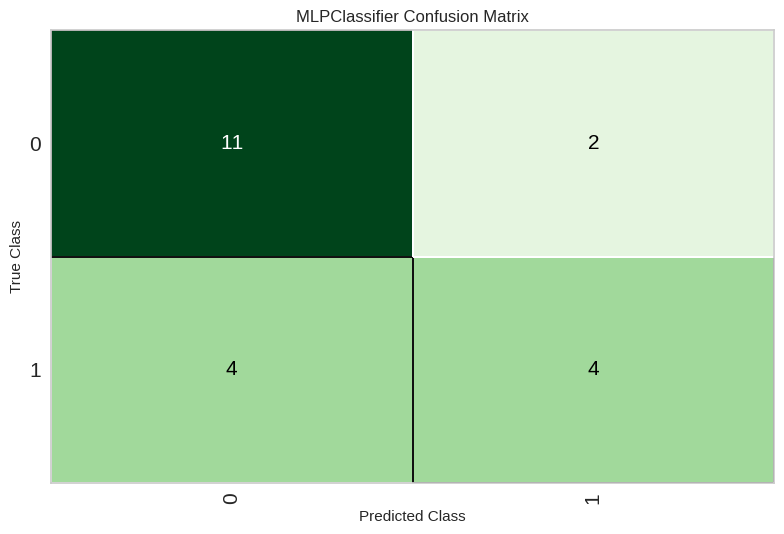


Accuracy train: 0.65 
 Accuracy test: 0.7143 
 F1 score train: 0.4778 
 F1 score test: 0.5714
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "RANDOM FOREST" WITH METHOD "UNIVARIATE" 



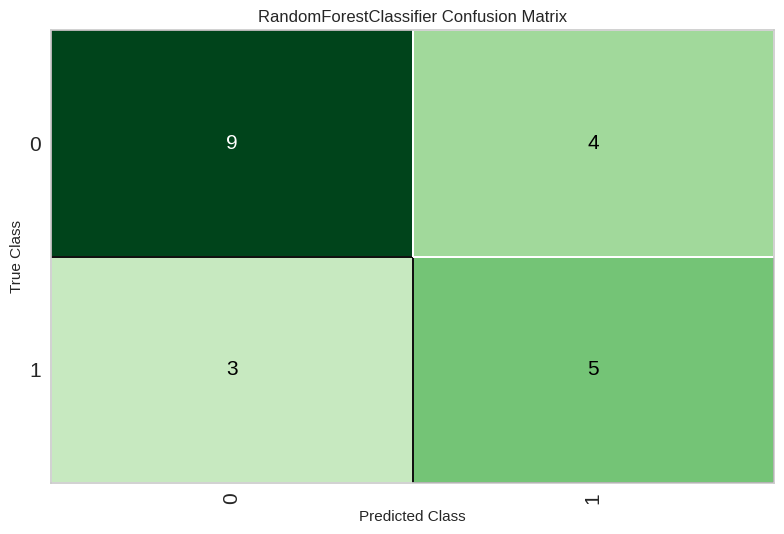


Accuracy train: 0.6167 
 Accuracy test: 0.6667 
 F1 score train: 0.4056 
 F1 score test: 0.5882
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "RANDOM FOREST" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



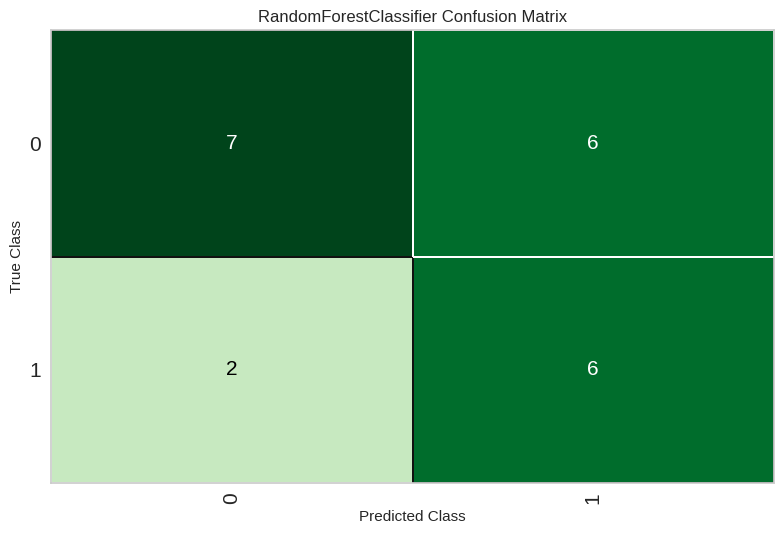


Accuracy train: 0.55 
 Accuracy test: 0.619 
 F1 score train: 0.5721 
 F1 score test: 0.6
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "XG BOOST" WITH METHOD "UNIVARIATE" 



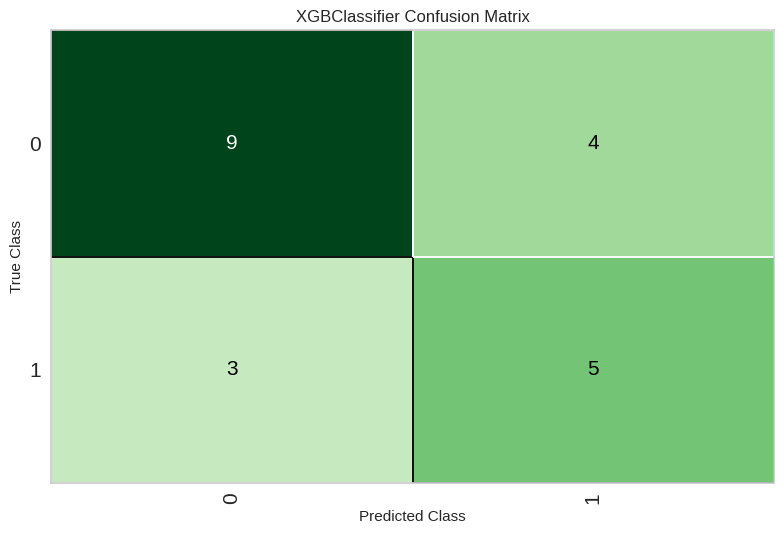


Accuracy train: 0.5667 
 Accuracy test: 0.6667 
 F1 score train: 0.3547 
 F1 score test: 0.5882
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "XG BOOST" WITH METHOD "UNIVARIATE" AND GRID SEARCH 



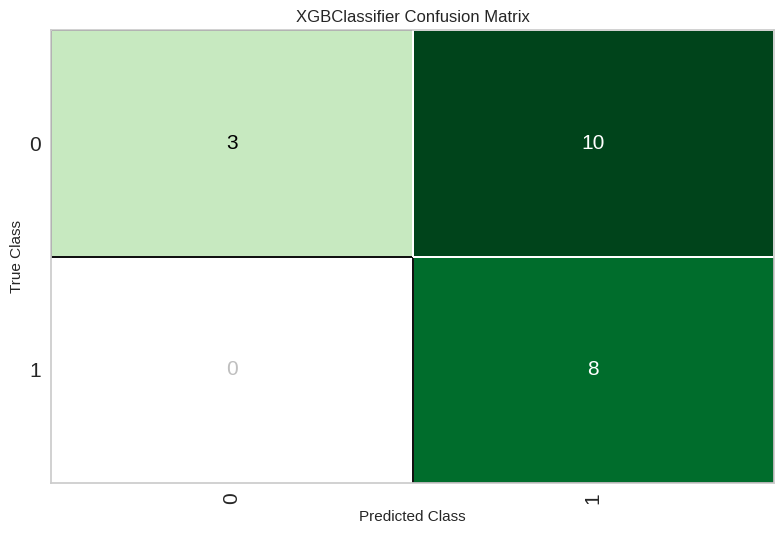


Accuracy train: 0.5667 
 Accuracy test: 0.5238 
 F1 score train: 0.6175 
 F1 score test: 0.6154
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "LOGISTIC REGRESSION" WITH METHOD "CLASSIC" 



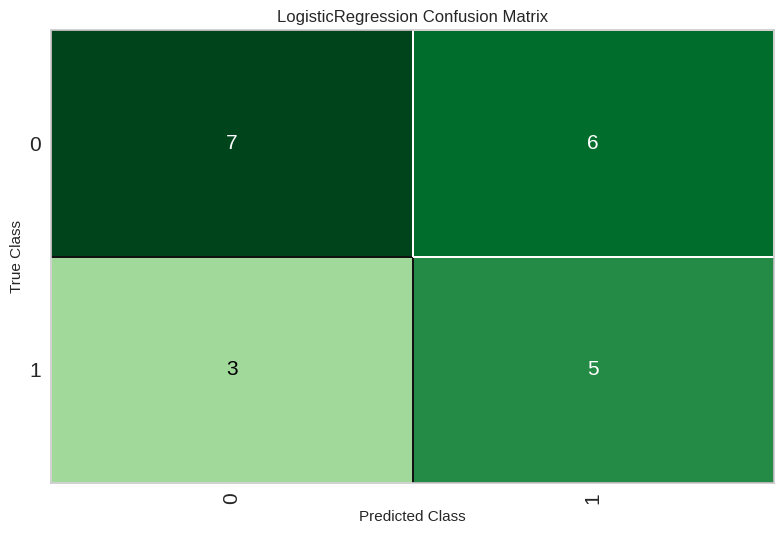


Accuracy train: 0.5833 
 Accuracy test: 0.5714 
 F1 score train: 0.3739 
 F1 score test: 0.5263
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "LOGISTIC REGRESSION" WITH METHOD "CLASSIC" AND GRID SEARCH 



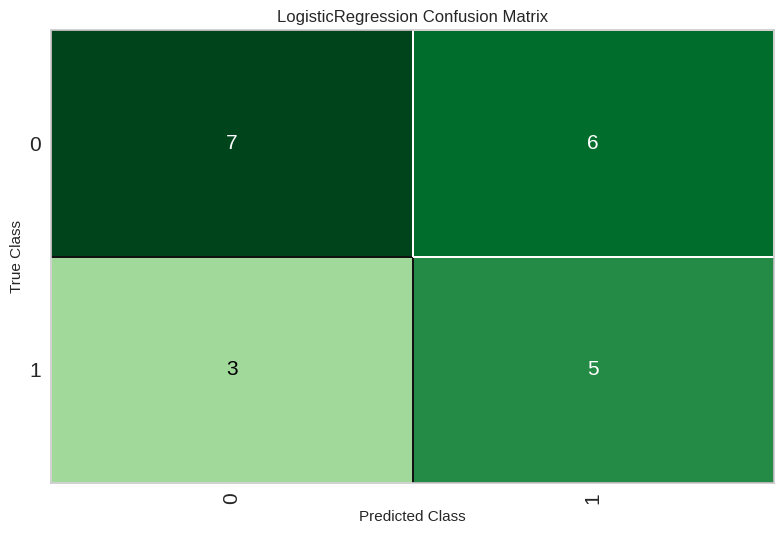


Accuracy train: 0.55 
 Accuracy test: 0.5714 
 F1 score train: 0.4611 
 F1 score test: 0.5263
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "K-NEAREST NEIGHBORS" WITH METHOD "CLASSIC" 



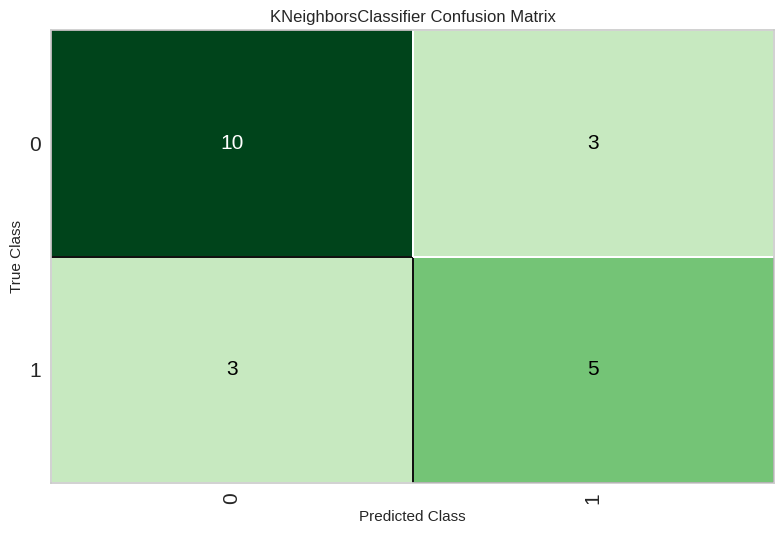


Accuracy train: 0.6833 
 Accuracy test: 0.7143 
 F1 score train: 0.528 
 F1 score test: 0.625
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "K-NEAREST NEIGHBORS" WITH METHOD "CLASSIC" AND GRID SEARCH 



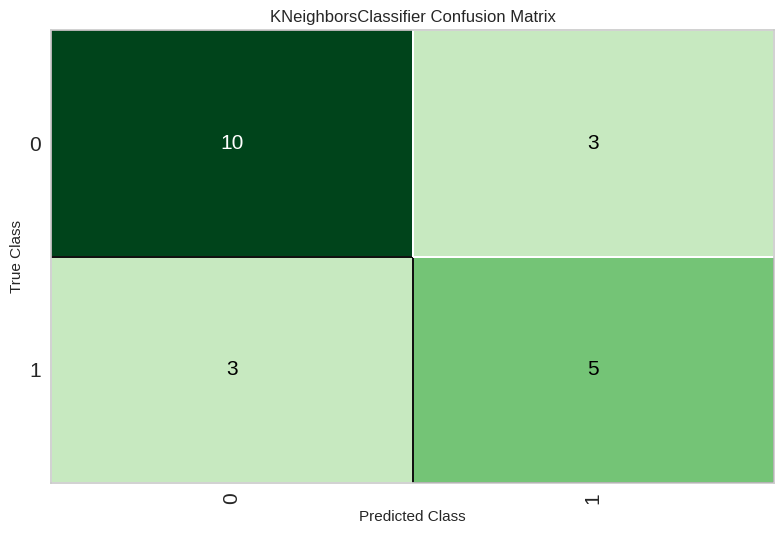


Accuracy train: 0.7 
 Accuracy test: 0.7143 
 F1 score train: 0.4755 
 F1 score test: 0.625
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "NAIVE BAYES" WITH METHOD "CLASSIC" 



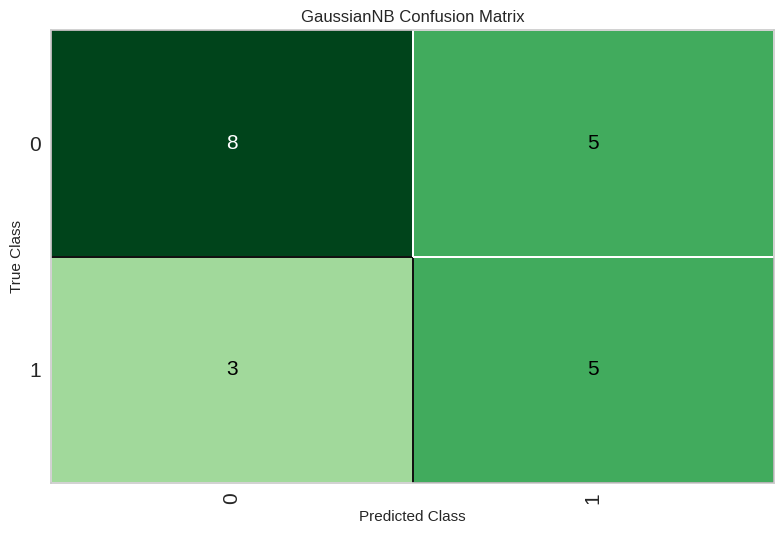


Accuracy train: 0.4167 
 Accuracy test: 0.619 
 F1 score train: 0.5148 
 F1 score test: 0.5556
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "NAIVE BAYES" WITH METHOD "CLASSIC" AND GRID SEARCH 



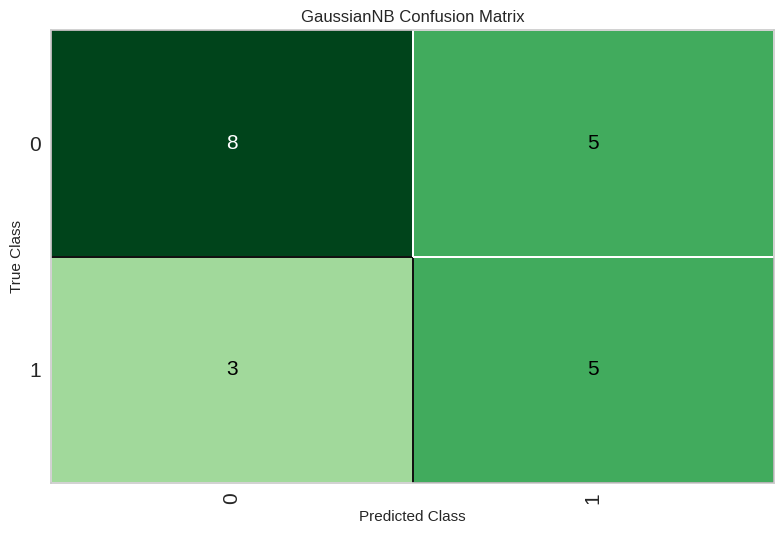


Accuracy train: 0.4167 
 Accuracy test: 0.619 
 F1 score train: 0.5148 
 F1 score test: 0.5556
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "DECISION TREE" WITH METHOD "CLASSIC" 



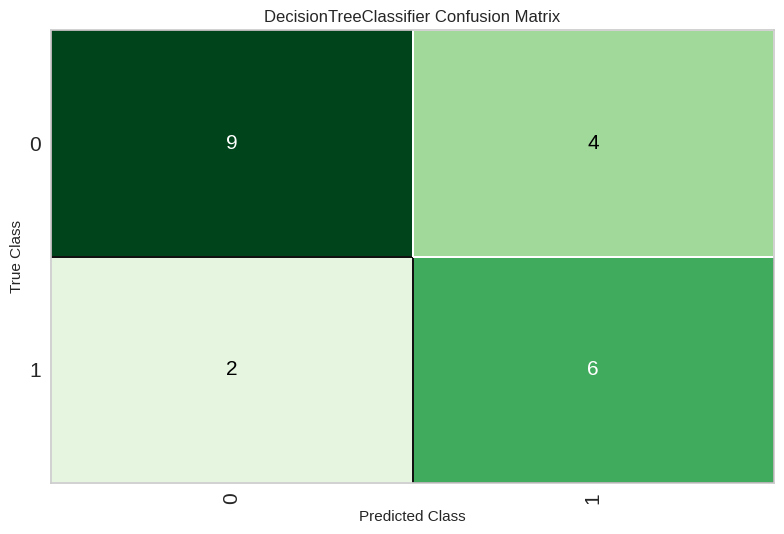


Accuracy train: 0.6 
 Accuracy test: 0.7143 
 F1 score train: 0.4449 
 F1 score test: 0.6667
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "DECISION TREE" WITH METHOD "CLASSIC" AND GRID SEARCH 



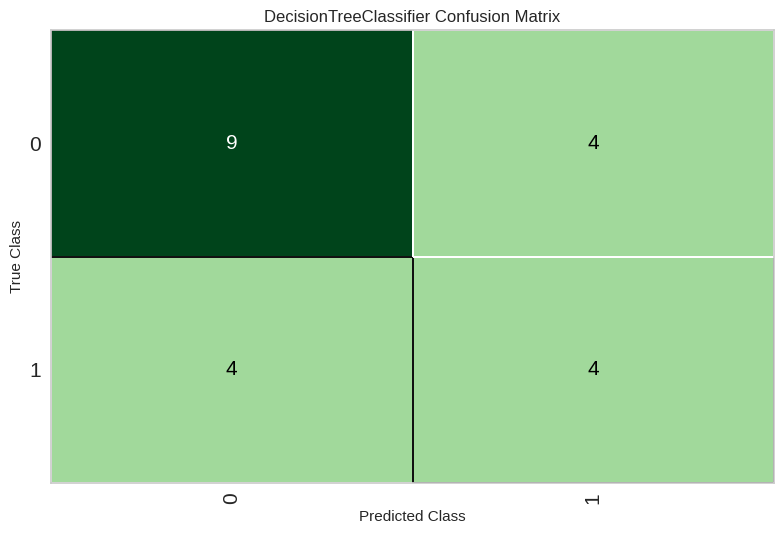


Accuracy train: 0.6167 
 Accuracy test: 0.619 
 F1 score train: 0.4949 
 F1 score test: 0.5
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "SVM- LINEAR KERNEL" WITH METHOD "CLASSIC" 



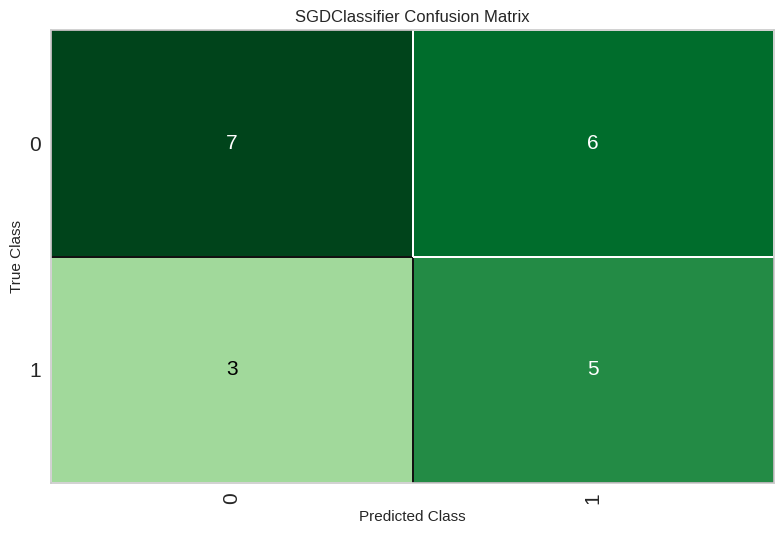


Accuracy train: 0.5167 
 Accuracy test: 0.5714 
 F1 score train: 0.3371 
 F1 score test: 0.5263
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "SVM- LINEAR KERNEL" WITH METHOD "CLASSIC" AND GRID SEARCH 



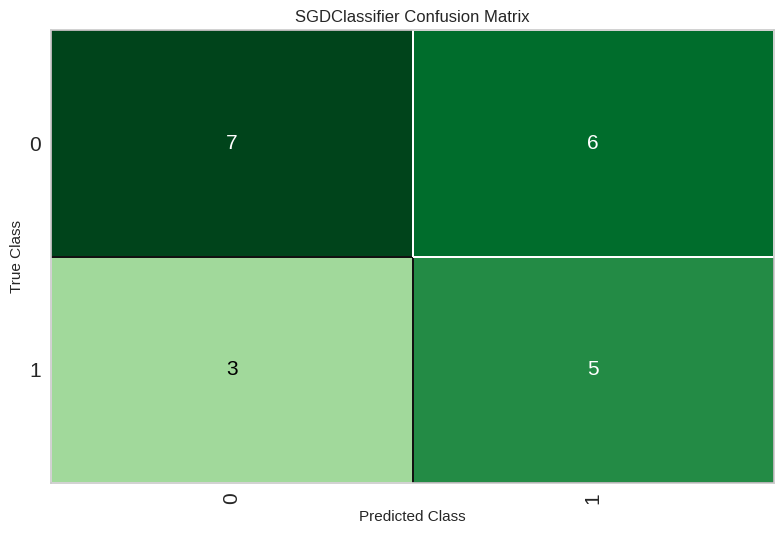


Accuracy train: 0.5833 
 Accuracy test: 0.5714 
 F1 score train: 0.4981 
 F1 score test: 0.5263
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "SVM- RADIAL KERNEL" WITH METHOD "CLASSIC" 



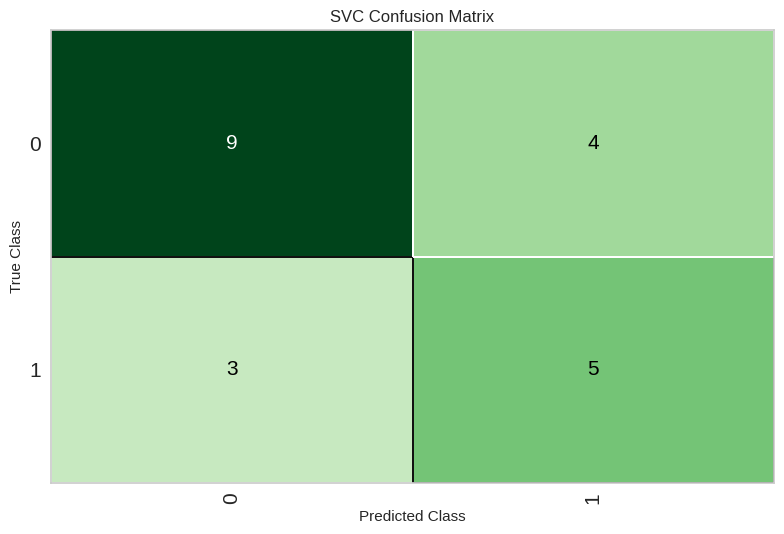


Accuracy train: 0.7 
 Accuracy test: 0.6667 
 F1 score train: 0.4 
 F1 score test: 0.5882
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "SVM- RADIAL KERNEL" WITH METHOD "CLASSIC" AND GRID SEARCH 



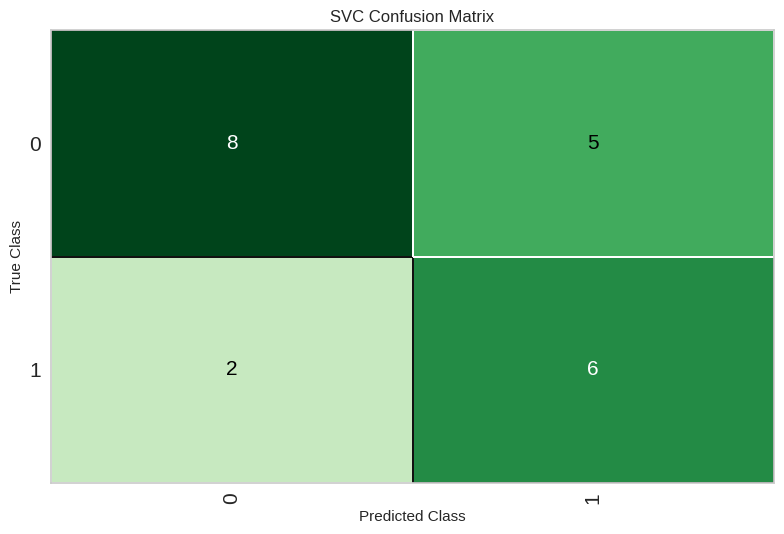


Accuracy train: 0.65 
 Accuracy test: 0.6667 
 F1 score train: 0.5292 
 F1 score test: 0.6316
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "MULTI-LAYER PERCEPTRON" WITH METHOD "CLASSIC" 



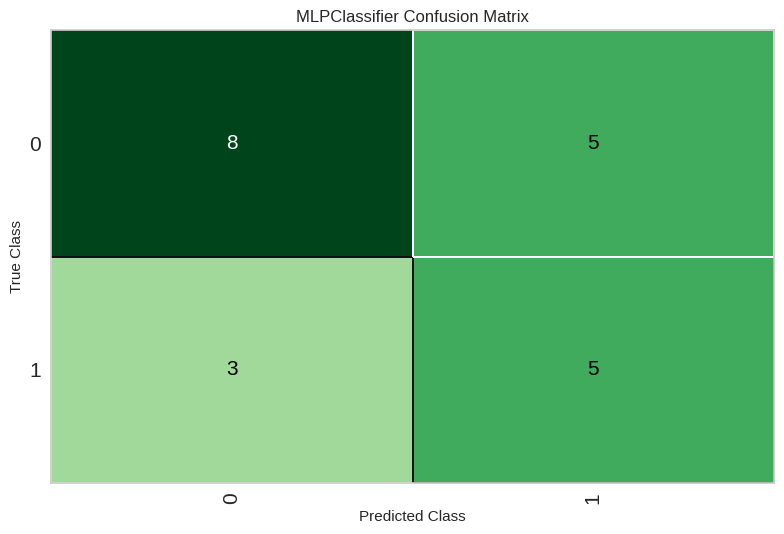


Accuracy train: 0.6167 
 Accuracy test: 0.619 
 F1 score train: 0.456 
 F1 score test: 0.5556
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "MULTI-LAYER PERCEPTRON" WITH METHOD "CLASSIC" AND GRID SEARCH 



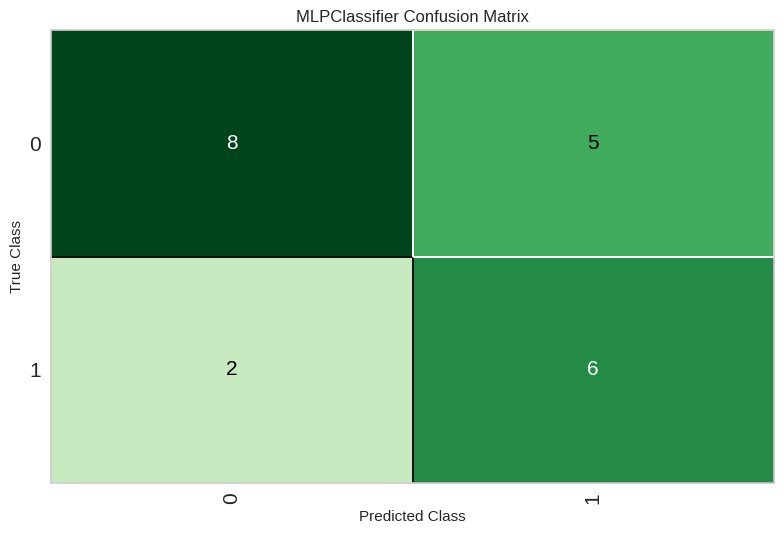


Accuracy train: 0.6167 
 Accuracy test: 0.6667 
 F1 score train: 0.4847 
 F1 score test: 0.6316
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "RANDOM FOREST" WITH METHOD "CLASSIC" 



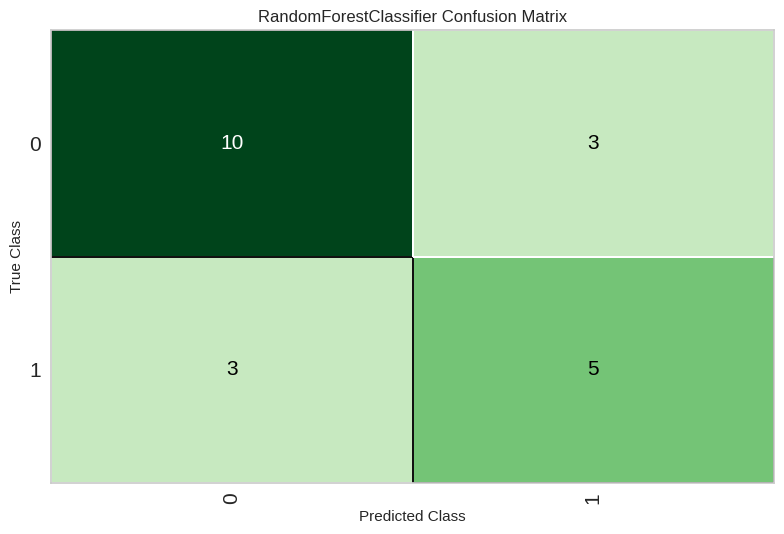


Accuracy train: 0.6167 
 Accuracy test: 0.7143 
 F1 score train: 0.3806 
 F1 score test: 0.625
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "RANDOM FOREST" WITH METHOD "CLASSIC" AND GRID SEARCH 



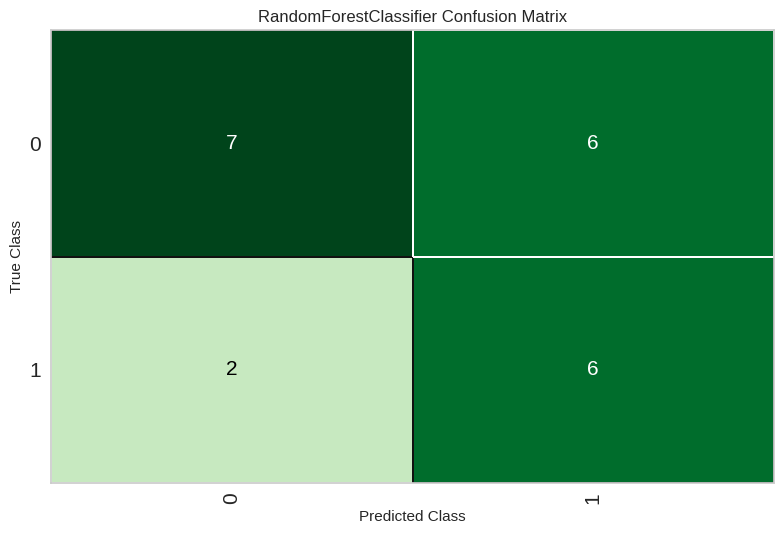


Accuracy train: 0.4667 
 Accuracy test: 0.619 
 F1 score train: 0.5952 
 F1 score test: 0.6
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "XG BOOST" WITH METHOD "CLASSIC" 



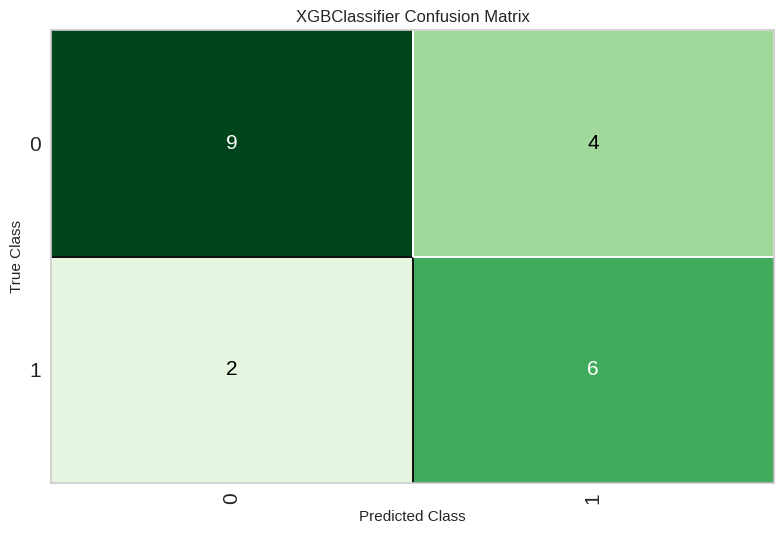


Accuracy train: 0.6167 
 Accuracy test: 0.7143 
 F1 score train: 0.4072 
 F1 score test: 0.6667
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "XG BOOST" WITH METHOD "CLASSIC" AND GRID SEARCH 



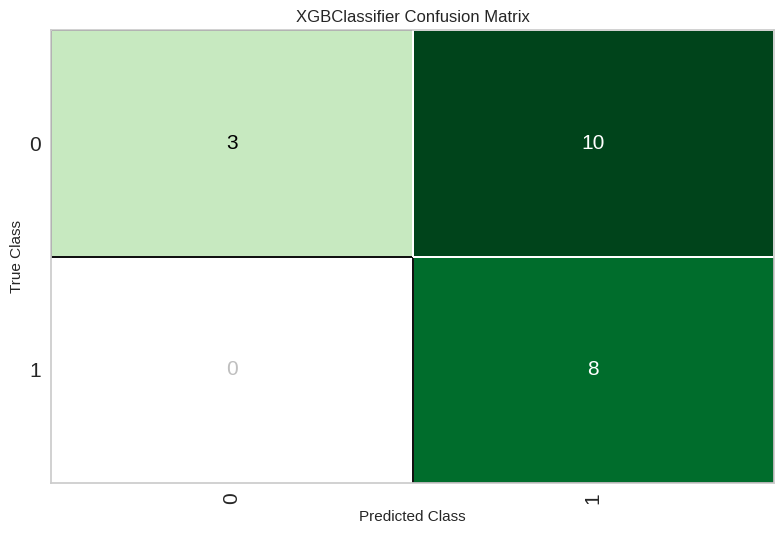


Accuracy train: 0.45 
 Accuracy test: 0.5238 
 F1 score train: 0.5848 
 F1 score test: 0.6154
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "LOGISTIC REGRESSION" WITH METHOD "SEQUENTIAL" 



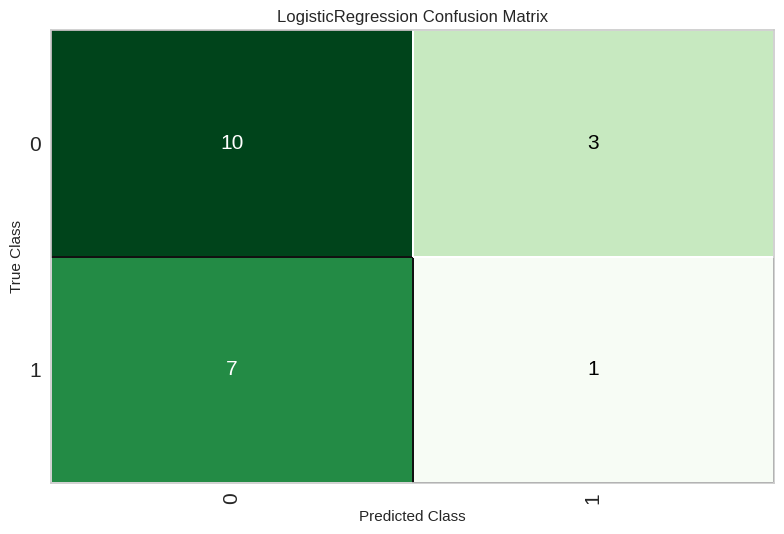


Accuracy train: 0.5833 
 Accuracy test: 0.5238 
 F1 score train: 0.3209 
 F1 score test: 0.1667
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "LOGISTIC REGRESSION" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



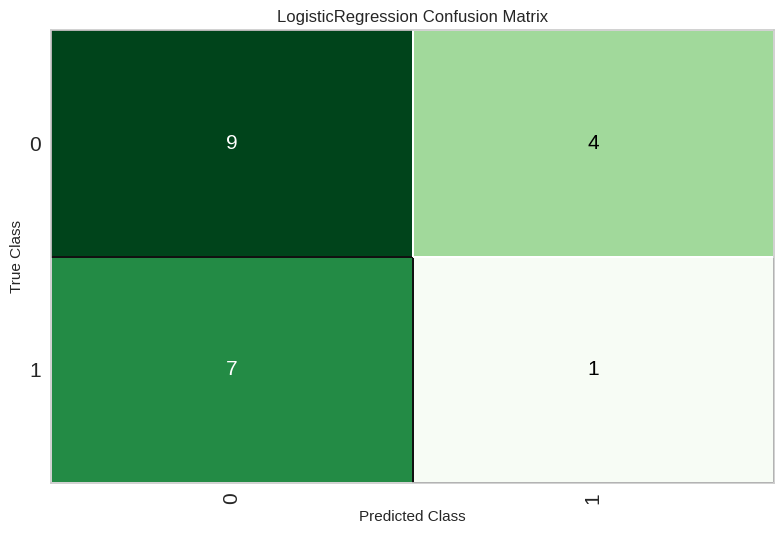


Accuracy train: 0.4667 
 Accuracy test: 0.4762 
 F1 score train: 0.4553 
 F1 score test: 0.1538
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "K-NEAREST NEIGHBORS" WITH METHOD "SEQUENTIAL" 



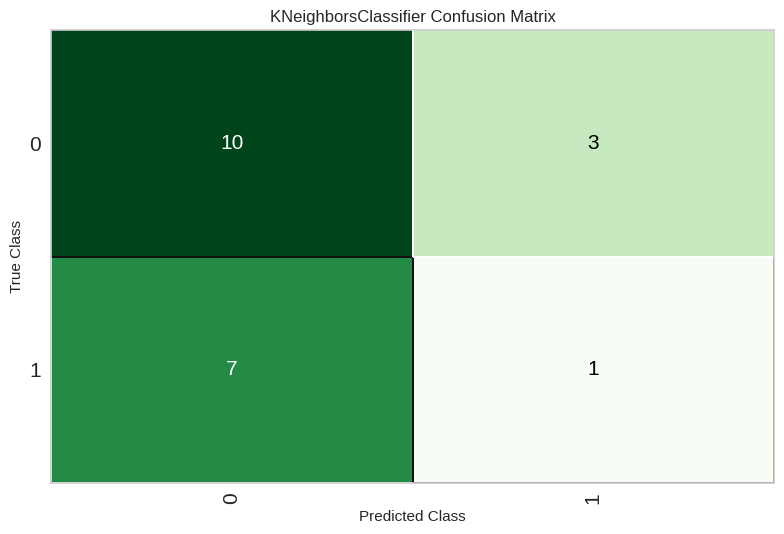


Accuracy train: 0.5333 
 Accuracy test: 0.5238 
 F1 score train: 0.4966 
 F1 score test: 0.1667
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "K-NEAREST NEIGHBORS" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



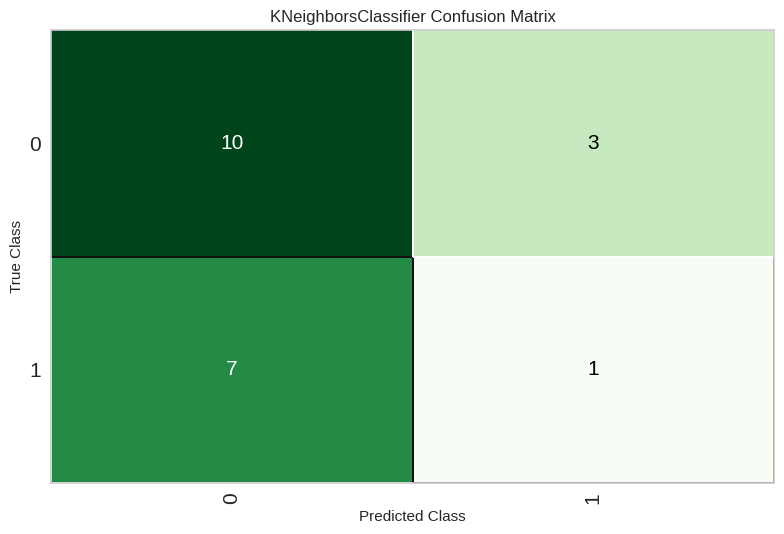


Accuracy train: 0.7167 
 Accuracy test: 0.5238 
 F1 score train: 0.5278 
 F1 score test: 0.1667
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "NAIVE BAYES" WITH METHOD "SEQUENTIAL" 



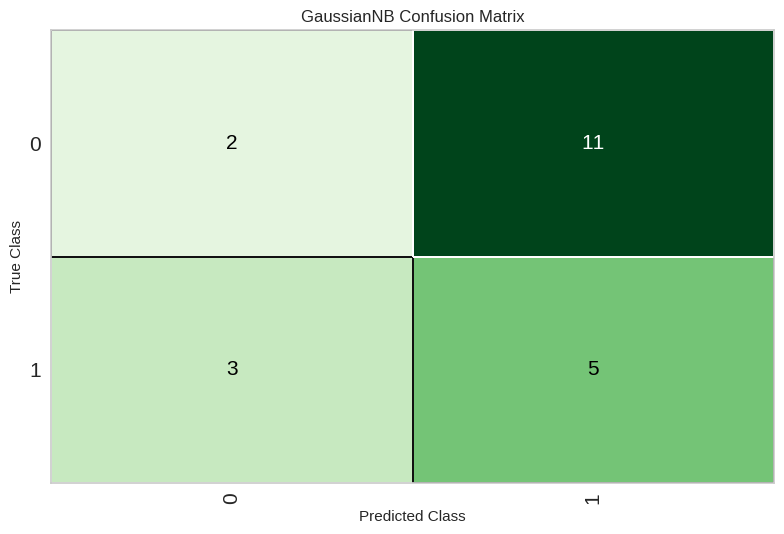


Accuracy train: 0.4167 
 Accuracy test: 0.3333 
 F1 score train: 0.5421 
 F1 score test: 0.4167
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "NAIVE BAYES" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



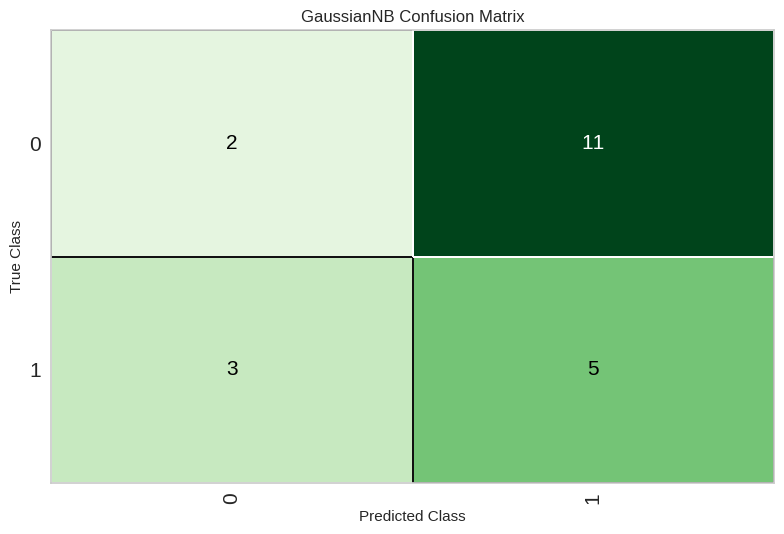


Accuracy train: 0.45 
 Accuracy test: 0.3333 
 F1 score train: 0.5571 
 F1 score test: 0.4167
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "DECISION TREE" WITH METHOD "SEQUENTIAL" 



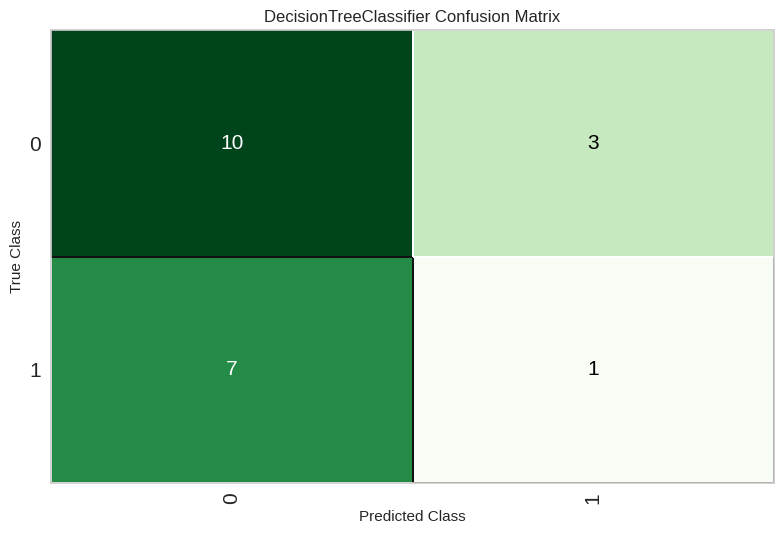


Accuracy train: 0.65 
 Accuracy test: 0.5238 
 F1 score train: 0.4714 
 F1 score test: 0.1667
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "DECISION TREE" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



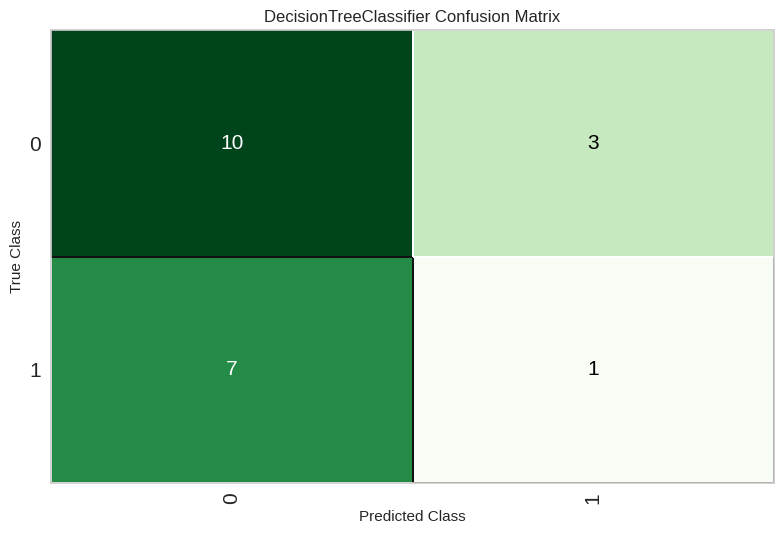


Accuracy train: 0.6333 
 Accuracy test: 0.5238 
 F1 score train: 0.4419 
 F1 score test: 0.1667
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "SVM- LINEAR KERNEL" WITH METHOD "SEQUENTIAL" 



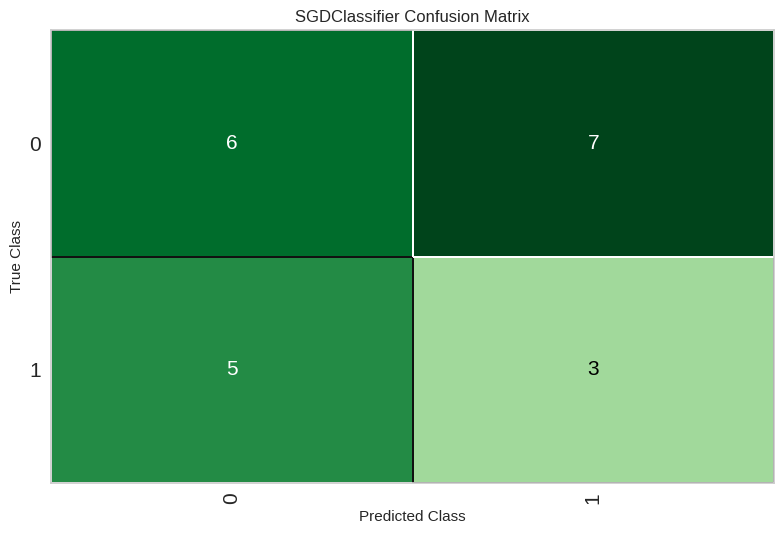


Accuracy train: 0.45 
 Accuracy test: 0.4286 
 F1 score train: 0.2419 
 F1 score test: 0.3333
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "SVM- LINEAR KERNEL" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



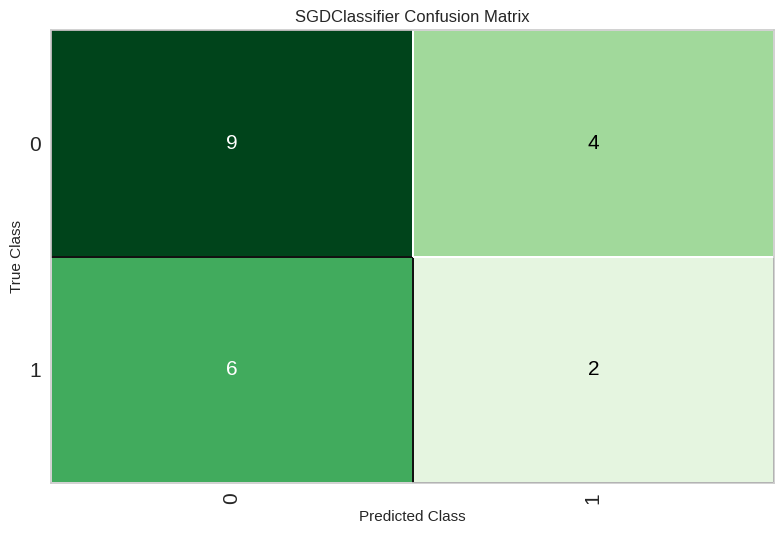


Accuracy train: 0.5167 
 Accuracy test: 0.5238 
 F1 score train: 0.4187 
 F1 score test: 0.2857
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "SVM- RADIAL KERNEL" WITH METHOD "SEQUENTIAL" 



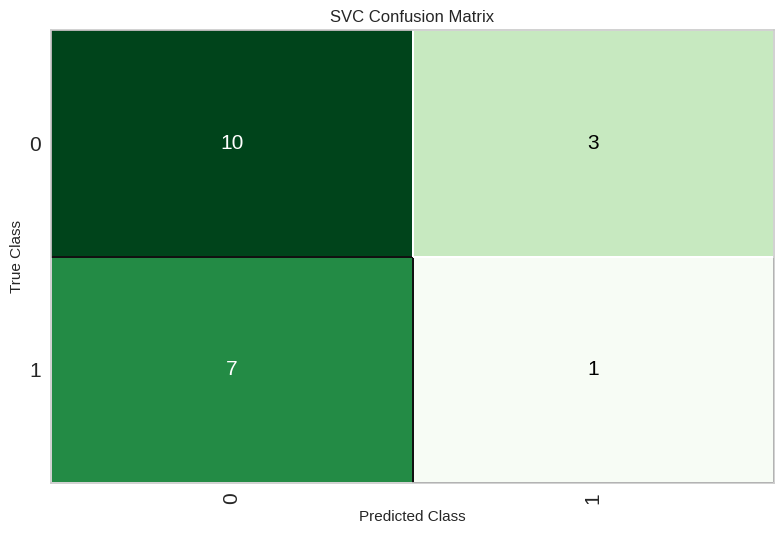


Accuracy train: 0.5667 
 Accuracy test: 0.5238 
 F1 score train: 0.2431 
 F1 score test: 0.1667
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "SVM- RADIAL KERNEL" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



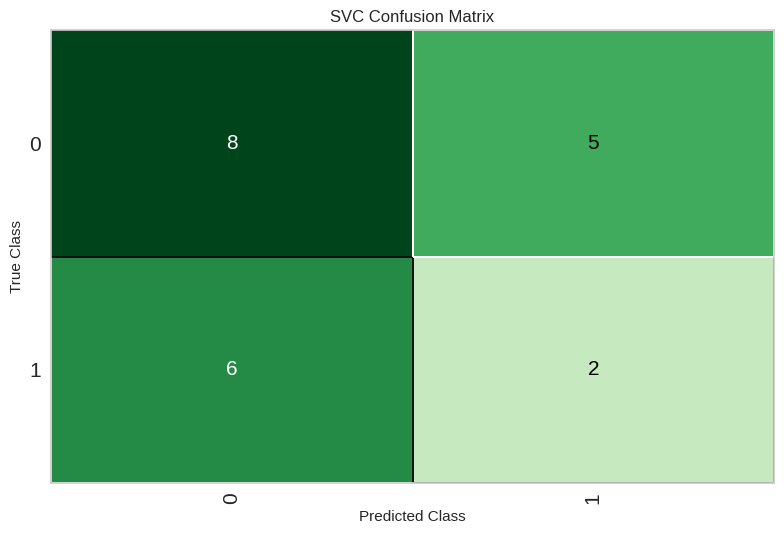


Accuracy train: 0.5167 
 Accuracy test: 0.4762 
 F1 score train: 0.4891 
 F1 score test: 0.2667
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "MULTI-LAYER PERCEPTRON" WITH METHOD "SEQUENTIAL" 



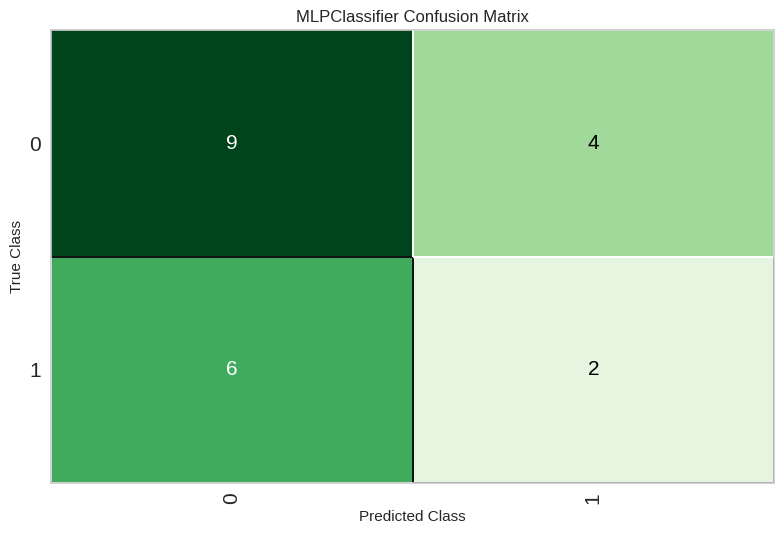


Accuracy train: 0.6167 
 Accuracy test: 0.5238 
 F1 score train: 0.4808 
 F1 score test: 0.2857
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "MULTI-LAYER PERCEPTRON" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



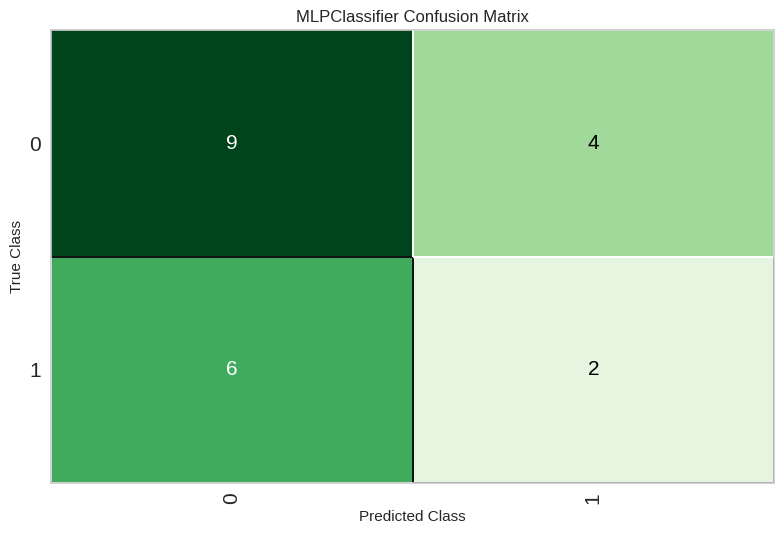


Accuracy train: 0.65 
 Accuracy test: 0.5238 
 F1 score train: 0.4663 
 F1 score test: 0.2857
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "RANDOM FOREST" WITH METHOD "SEQUENTIAL" 



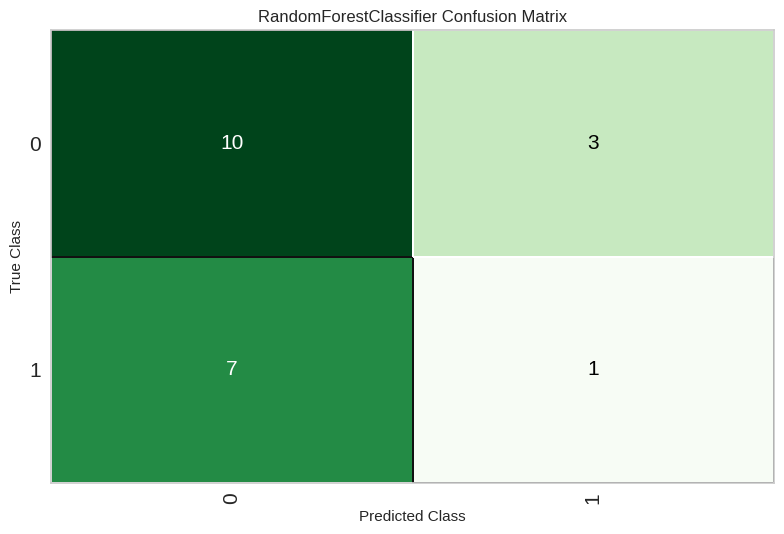


Accuracy train: 0.6833 
 Accuracy test: 0.5238 
 F1 score train: 0.5116 
 F1 score test: 0.1667
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "RANDOM FOREST" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



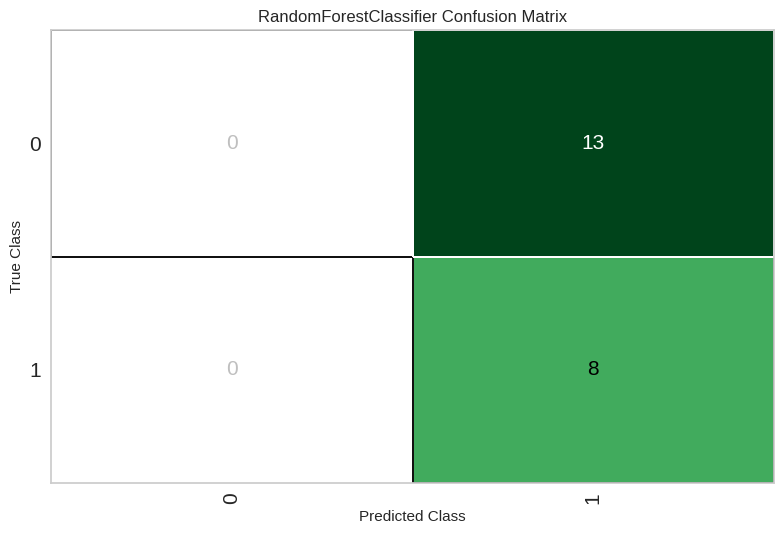


Accuracy train: 0.3833 
 Accuracy test: 0.381 
 F1 score train: 0.5536 
 F1 score test: 0.5517
------------------------------------------------------------------------------------------ 

CONFUSION MATRIX FOR MODEL "XG BOOST" WITH METHOD "SEQUENTIAL" 



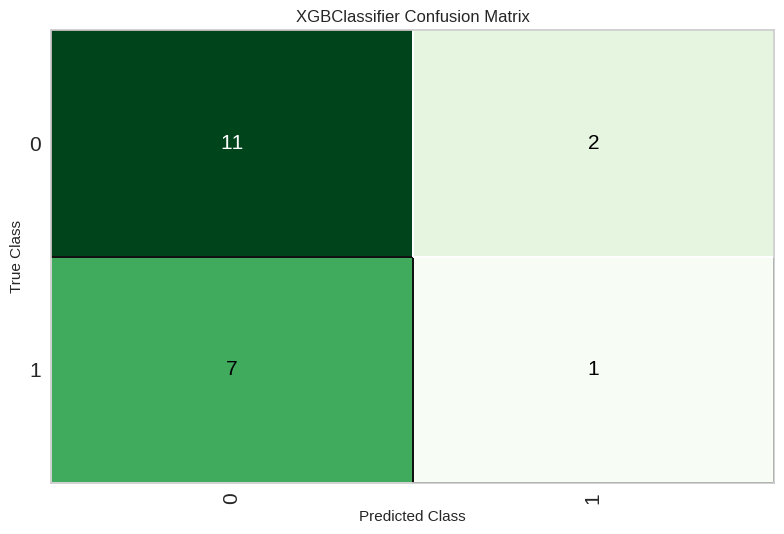


Accuracy train: 0.6333 
 Accuracy test: 0.5714 
 F1 score train: 0.435 
 F1 score test: 0.1818
----------------------------------------------------------------------------------- 

CONFUSION MATRIX FOR MODEL "XG BOOST" WITH METHOD "SEQUENTIAL" AND GRID SEARCH 



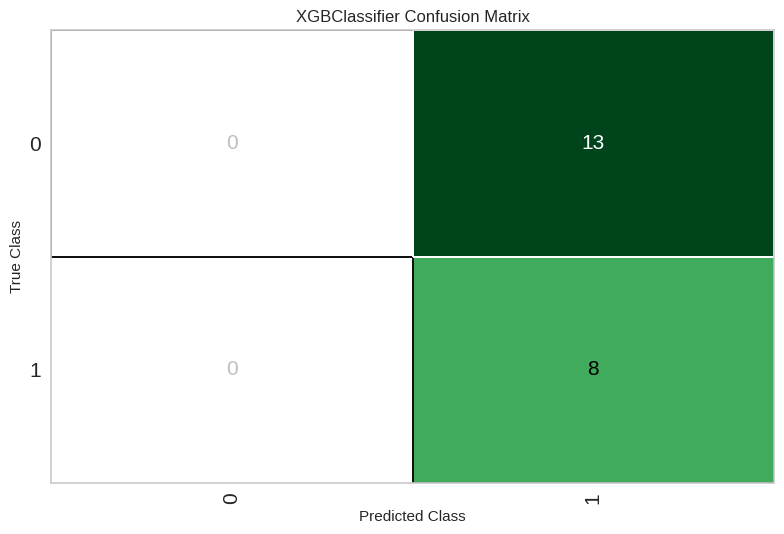


Accuracy train: 0.4833 
 Accuracy test: 0.381 
 F1 score train: 0.5644 
 F1 score test: 0.5517
------------------------------------------------------------------------------------------ 



In [ ]:
#Loops para iterar los distintos modelos y metodos de feature selection

db_copy=data.copy()
db_copy.columns=db_copy.columns.str.replace('[^a-zA-Z0-9_]', ' ', regex=True)

for method in feature_selection_methods:

  # Configurar el modelo con el metodo de selección de características especificado
  model_setup= setup(data= db_copy, target='target', session_id=42, train_size= 0.75 , fold= 4,
                      feature_selection = True, feature_selection_method = method,
                      n_features_to_select= 0.4, normalize= True, remove_multicollinearity=True, verbose= False)

  for select_model in models_list:

    # Crear y entrenar el modelo
    model= create_model(select_model, fold=4, verbose=False)

    #Evaluar el modelo sin optimizar(train)
    train_metrics = pull()
    acc_train = train_metrics['Accuracy']['Mean']
    F1_train = train_metrics['F1']['Mean']

    #Evaluar el modelo (test)
    prediction= predict_model(model, verbose= False)
    test_metrics = pull()
    acc_test = test_metrics['Accuracy'][0]
    F1_test = test_metrics['F1'][0]

    #Matriz de confusion
    print(f'CONFUSION MATRIX FOR MODEL "{models[select_model].upper()}" WITH METHOD "{method.upper()}" \n')
    plot_model(model, plot='confusion_matrix', verbose= False)
    print('')
    print(f'Accuracy train: {acc_train} \n Accuracy test: {acc_test} \n F1 score train: {F1_train} \n F1 score test: {F1_test}')
    print('----------------------------------------------------------------------------------- \n')


    #Grilla de parametros
    hyperparameters= model.get_params()

    # Agregar los resultados al DataFrame
    Resultados.loc[len(Resultados)]={'Model': models[select_model], 'Feature Selection': method,
                   'Accuracy train': acc_train, 'Accuracy test': acc_test, 'F1-score train':F1_train,
                   'F1-score test':F1_test, 'Grid Search': False, 'Best Hyperparameters': hyperparameters}

    #Optimizar el modelo
    best_model=tune_model(model, fold=4, optimize='F1', verbose= False)

    #Evaluar el modelo afinado(train)
    train_metrics = pull()
    acc_train = train_metrics['Accuracy']['Mean']
    F1_train = train_metrics['F1']['Mean']

    #Evaluar el modelo afinado (test)
    prediction_best_model=predict_model(best_model, verbose= False)
    test_metrics = pull()
    acc_test = test_metrics['Accuracy'][0]
    F1_test = test_metrics['F1'][0]

    #Matriz de confusion
    print(f'CONFUSION MATRIX FOR MODEL "{models[select_model].upper()}" WITH METHOD "{method.upper()}" AND GRID SEARCH \n')
    plot_model(best_model, plot='confusion_matrix', verbose= False)
    print('')
    print(f'Accuracy train: {acc_train} \n Accuracy test: {acc_test} \n F1 score train: {F1_train} \n F1 score test: {F1_test}')
    print('------------------------------------------------------------------------------------------ \n')


    #Grilla de parametros
    hyperparameters= best_model.get_params()

    # Agregar los resultados al DataFrame
    Resultados.loc[len(Resultados)]={'Model': models[select_model], 'Feature Selection': method,
                   'Accuracy train': acc_train, 'Accuracy test': acc_test, 'F1-score train':F1_train,
                   'F1-score test':F1_test, 'Grid Search': True, 'Best Hyperparameters': hyperparameters}

    #demora 13 min

In [ ]:
#Revisar los resultados
Resultados.head(54)

,Model,Feature Selection,Accuracy train,Accuracy test,F1-score train,F1-score test,Grid Search,Best Hyperparameters
0,Logistic Regression,univariate,0.6333,0.7143,0.4292,0.5714,False,"{'C': 1.0, 'class_weight': None, 'dual': False..."
1,Logistic Regression,univariate,0.6833,0.7143,0.5530,0.6667,True,"{'C': 0.431, 'class_weight': 'balanced', 'dual..."
2,K-Nearest Neighbors,univariate,0.6833,0.7143,0.5069,0.7000,False,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
3,K-Nearest Neighbors,univariate,0.6500,0.7143,0.4708,0.7000,True,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
4,Naive Bayes,univariate,0.6333,0.6190,0.3919,0.2000,False,"{'priors': None, 'var_smoothing': 1e-09}"
5,Naive Bayes,univariate,0.6667,0.5714,0.4727,0.1818,True,"{'priors': None, 'var_smoothing': 0.003}"
6,Decision Tree,univariate,0.5833,0.7143,0.3100,0.6667,False,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
7,Decision Tree,univariate,0.6167,0.7619,0.4583,0.6154,True,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
8,SVM- Linear Kernel,univariate,0.6167,0.6667,0.3986,0.6316,False,"{'alpha': 0.0001, 'average': False, 'class_wei..."
9,SVM- Linear Kernel,univariate,0.5833,0.6190,0.6009,0.6000,True,"{'alpha': 0.2, 'average': False, 'class_weight..."


In [ ]:
#Ordenar los resultados por modelo y feature selection
Resultados=Resultados.sort_values(by=['Model', 'Feature Selection', 'Grid Search'])

In [ ]:
#Guardar los resultados
Resultados.to_excel('Resultados.xlsx', encoding='utf8', index = False)

## Visualizacion de los resultados obtenidos

In [ ]:
Resultados[Resultados['Grid Search']==True].sort_values('F1-score test', ascending=False).head(10)

,Model,Feature Selection,Accuracy train,Accuracy test,F1-score train,F1-score test,Grid Search,Best Hyperparameters
3,K-Nearest Neighbors,univariate,0.6500,0.7143,0.4708,0.7000,True,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
1,Logistic Regression,univariate,0.6833,0.7143,0.5530,0.6667,True,"{'C': 0.431, 'class_weight': 'balanced', 'dual..."
31,Multi-Layer Perceptron,classic,0.6167,0.6667,0.4847,0.6316,True,"{'activation': 'relu', 'alpha': 0.2, 'batch_si..."
29,SVM- Radial Kernel,classic,0.6500,0.6667,0.5292,0.6316,True,"{'C': 41.61, 'break_ties': False, 'cache_size'..."
21,K-Nearest Neighbors,classic,0.7000,0.7143,0.4755,0.6250,True,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
35,XG Boost,classic,0.4500,0.5238,0.5848,0.6154,True,"{'objective': 'binary:logistic', 'use_label_en..."
17,XG Boost,univariate,0.5667,0.5238,0.6175,0.6154,True,"{'objective': 'binary:logistic', 'use_label_en..."
7,Decision Tree,univariate,0.6167,0.7619,0.4583,0.6154,True,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
9,SVM- Linear Kernel,univariate,0.5833,0.6190,0.6009,0.6000,True,"{'alpha': 0.2, 'average': False, 'class_weight..."
33,Random Forest,classic,0.4667,0.6190,0.5952,0.6000,True,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."


In [ ]:
Resultados[Resultados['Grid Search']==False].sort_values('F1-score test', ascending=False).head(10)

,Model,Feature Selection,Accuracy train,Accuracy test,F1-score train,F1-score test,Grid Search,Best Hyperparameters
2,K-Nearest Neighbors,univariate,0.6833,0.7143,0.5069,0.7000,False,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
24,Decision Tree,classic,0.6000,0.7143,0.4449,0.6667,False,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
6,Decision Tree,univariate,0.5833,0.7143,0.3100,0.6667,False,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
34,XG Boost,classic,0.6167,0.7143,0.4072,0.6667,False,"{'objective': 'binary:logistic', 'use_label_en..."
8,SVM- Linear Kernel,univariate,0.6167,0.6667,0.3986,0.6316,False,"{'alpha': 0.0001, 'average': False, 'class_wei..."
20,K-Nearest Neighbors,classic,0.6833,0.7143,0.5280,0.6250,False,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
32,Random Forest,classic,0.6167,0.7143,0.3806,0.6250,False,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
12,Multi-Layer Perceptron,univariate,0.6667,0.6667,0.4514,0.5882,False,"{'activation': 'relu', 'alpha': 0.0001, 'batch..."
28,SVM- Radial Kernel,classic,0.7000,0.6667,0.4000,0.5882,False,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
14,Random Forest,univariate,0.6167,0.6667,0.4056,0.5882,False,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."


In [ ]:
#Grafico para top 10 de los mejores modelos
def top_models(df, metric):

  # Ordenar los modelos por F1-score en orden descendente
  results_sorted = df.sort_values(metric, ascending=False).head(10)

  # Concatenar el nombre del modelo con el método de selección de características
  results_sorted['Modelos'] = results_sorted['Model'] + ' (' + results_sorted['Feature Selection'] + ')'

  # Crear el gráfico de barras horizontales
  plt.figure(figsize=(10, 6))
  plt.barh(results_sorted['Modelos'], results_sorted[metric], color=palette[4])
  plt.xlabel(metric)
  plt.ylabel('Modelos')
  plt.title(f'Mejores 10 modelos según {metric}')
  plt.tight_layout()
  plt.show()


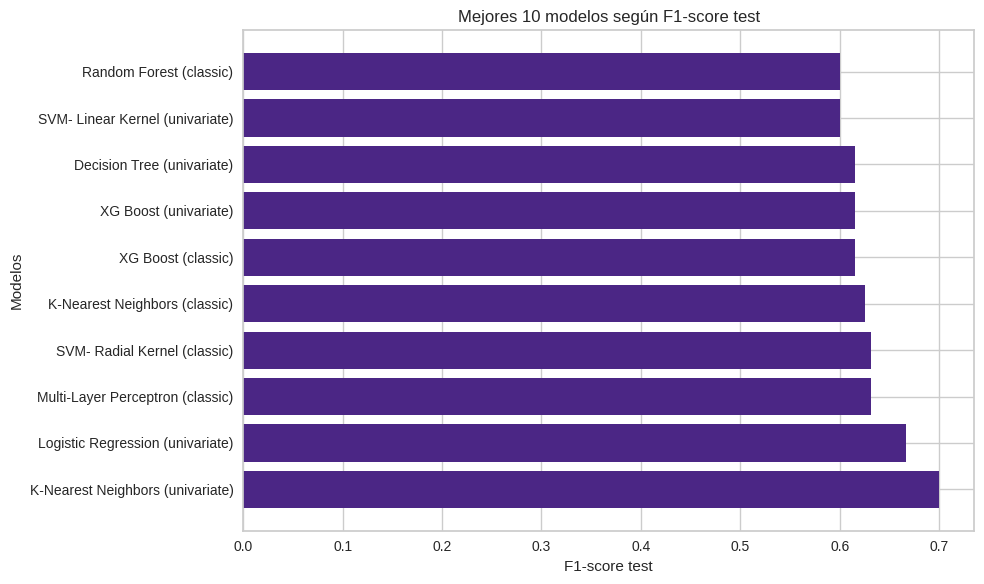

In [ ]:
#grafico de mejores modelos de la base de datos original
top_models(Resultados[Resultados['Grid Search']==True], 'F1-score test')

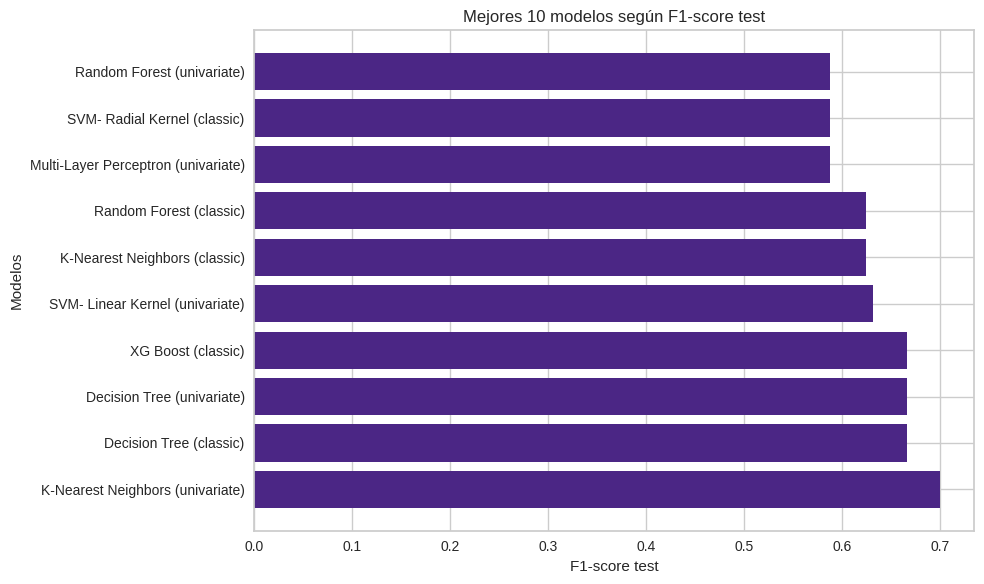

In [ ]:
#grafico de mejores modelos de la base de datos original
top_models(Resultados[Resultados['Grid Search']==False], 'F1-score test')

In [ ]:
#Grafico para metricas segun los metodos de feature selection
def feature_select(df, metric):
  # Obtener los modelos y los métodos únicos
  modelos_unicos= df['Model'].unique()
  metodos_unicos= df['Feature Selection'].unique()

  # Configurar el gráfico
  plt.figure(figsize=(10, 6))

  # Configurar el ancho de las barras
  width = 0.2

  # Calcular la posición de las barras en el eje x
  posiciones = range(len(modelos_unicos))

  # Crear las barras para cada método
  for i, metodo in enumerate(metodos_unicos):
    df_metodo = df[df['Feature Selection'] == metodo]
    metrica = df_metodo[metric]
    plt.bar([p + (width*i) for p in posiciones], metrica, width, label=metodo, color=palette[i+2])

  # Configurar los ejes y la leyenda
  plt.title(f'{metric} segun por Modelo y Feature Selection')
  plt.xticks([p + (width*(len(metodos_unicos)-1))/2 for p in posiciones], modelos_unicos, rotation=60)
  plt.legend()

  # Mostrar el gráfico
  plt.show()

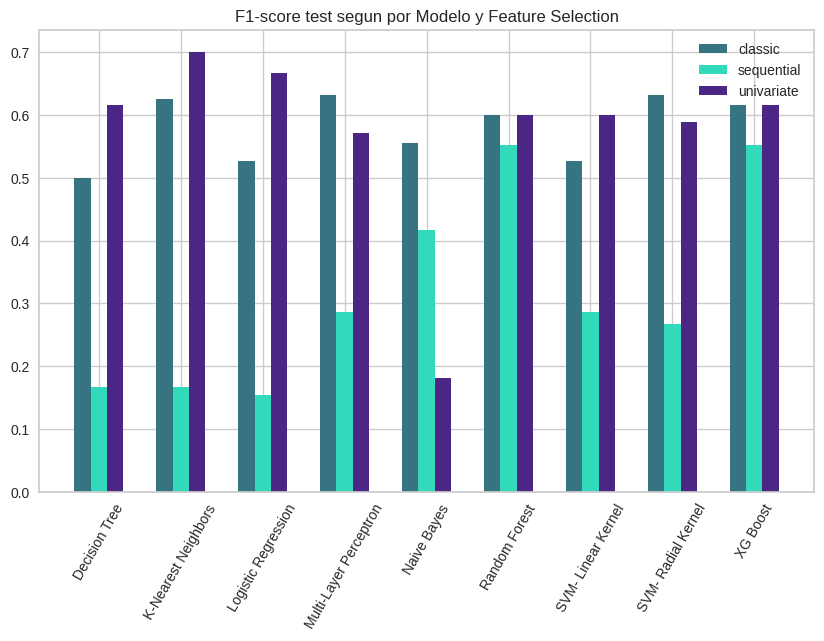

-----------------------------------------------------------------------------------------------------


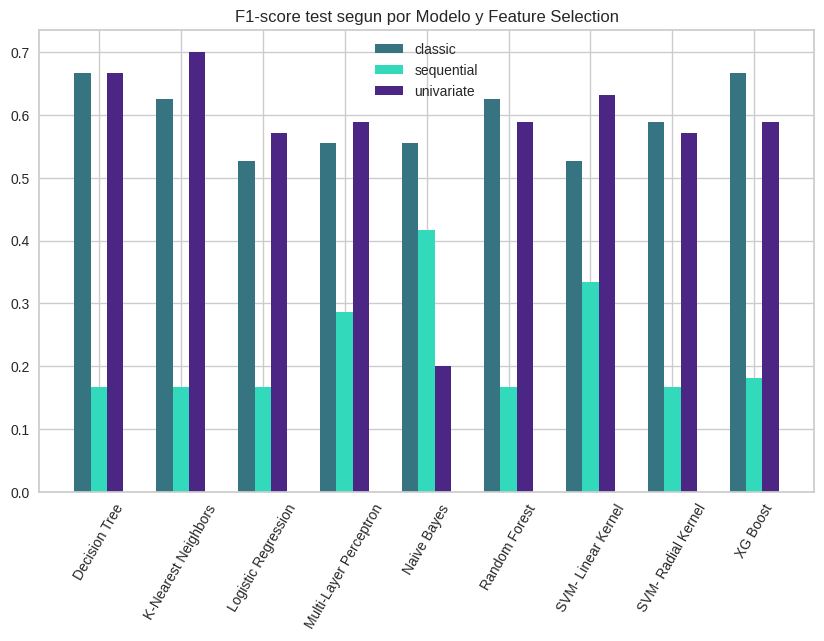

In [ ]:
# Graficos de F1 score de la base de datos original
feature_select(Resultados[Resultados['Grid Search']==True], 'F1-score test')
print('-----------------------------------------------------------------------------------------------------')
feature_select(Resultados[Resultados['Grid Search']==False], 'F1-score test')

In [ ]:
#Grafico para las metricas
def metrics(df_filtrado, method):

  models= df_filtrado['Model'][df_filtrado['Grid Search']==False].unique()
  models1= df_filtrado['Model'][df_filtrado['Grid Search']==True].unique()
  x= range(len(models))
  x1= range(len(models1))
  accuracy_train= df_filtrado['Accuracy train'][df_filtrado['Grid Search']==False]
  accuracy_test= df_filtrado['Accuracy test'][df_filtrado['Grid Search']==False]
  F1_train= df_filtrado['F1-score train'][df_filtrado['Grid Search']==False]
  F1_test= df_filtrado['F1-score test'][df_filtrado['Grid Search']==False]
  accuracy_train1= df_filtrado['Accuracy train'][df_filtrado['Grid Search']==True]
  accuracy_test1= df_filtrado['Accuracy test'][df_filtrado['Grid Search']==True]
  F1_train1= df_filtrado['F1-score train'][df_filtrado['Grid Search']==True]
  F1_test1= df_filtrado['F1-score test'][df_filtrado['Grid Search']==True]

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

  # Crear el gráfico de barras 1
  axs[0,0].bar(x, accuracy_train, width=0.4, label='Train', color=palette[3])
  axs[0,0].bar([i + 0.4 for i in x], accuracy_test, width=0.4, label='Test', color=palette[2])
  #axs[0,0].set_xlabel('Models')
  axs[0,0].set_ylabel('Accuracy')
  axs[0,0].set_title(f'Accuracy train/test with feature selection {method}')
  axs[0,0].set_xticks([i + 0.2 for i in x])
  axs[0,0].set_xticklabels(models, rotation=90)
  axs[0,0].legend(loc='upper left')

  # Crear el gráfico de barras 2
  axs[0,1].bar(x1, accuracy_train1, width=0.4, label='Train', color=palette[3])
  axs[0,1].bar([i + 0.4 for i in x1], accuracy_test1, width=0.4, label='Test', color=palette[2])
  #axs[0,1].set_xlabel('Models')
  axs[0,1].set_ylabel('Accuracy')
  axs[0,1].set_title(f'Accuracy train/test with feature selection {method} and Grid Search')
  axs[0,1].set_xticks([i + 0.2 for i in x1])
  axs[0,1].set_xticklabels(models1, rotation=90)
  axs[0,1].legend(loc='upper left')

  # Crear el gráfico de barras 3
  axs[1,0].bar(x, F1_train, width=0.4, label='Train', color=palette[5])
  axs[1,0].bar([i + 0.4 for i in x], F1_test, width=0.4, label='Test', color=palette[4])
  #axs[1,0].set_xlabel('Models')
  axs[1,0].set_ylabel('F1 score')
  axs[1,0].set_title(f'F1 score train/test with feature selection {method}')
  axs[1,0].set_xticks([i + 0.2 for i in x])
  axs[1,0].set_xticklabels(models, rotation=90)
  axs[1,0].legend(loc='upper left')

  # Crear el gráfico de barras 4
  axs[1,1].bar(x1, F1_train1, width=0.4, label='Train', color=palette[5])
  axs[1,1].bar([i + 0.4 for i in x1], F1_test1, width=0.4, label='Test', color=palette[4])
  #axs[1,1].set_xlabel('Models')
  axs[1,1].set_ylabel('F1 score')
  axs[1,1].set_title(f'F1 score train/test with feature selection {method} and Grid Search')
  axs[1,1].set_xticks([i + 0.2 for i in x1])
  axs[1,1].set_xticklabels(models1, rotation=90)
  axs[1,1].legend(loc='upper left')

  # Ajustar los espacios entre subplots
  plt.tight_layout()
  # Mostrar el gráfico
  plt.show()

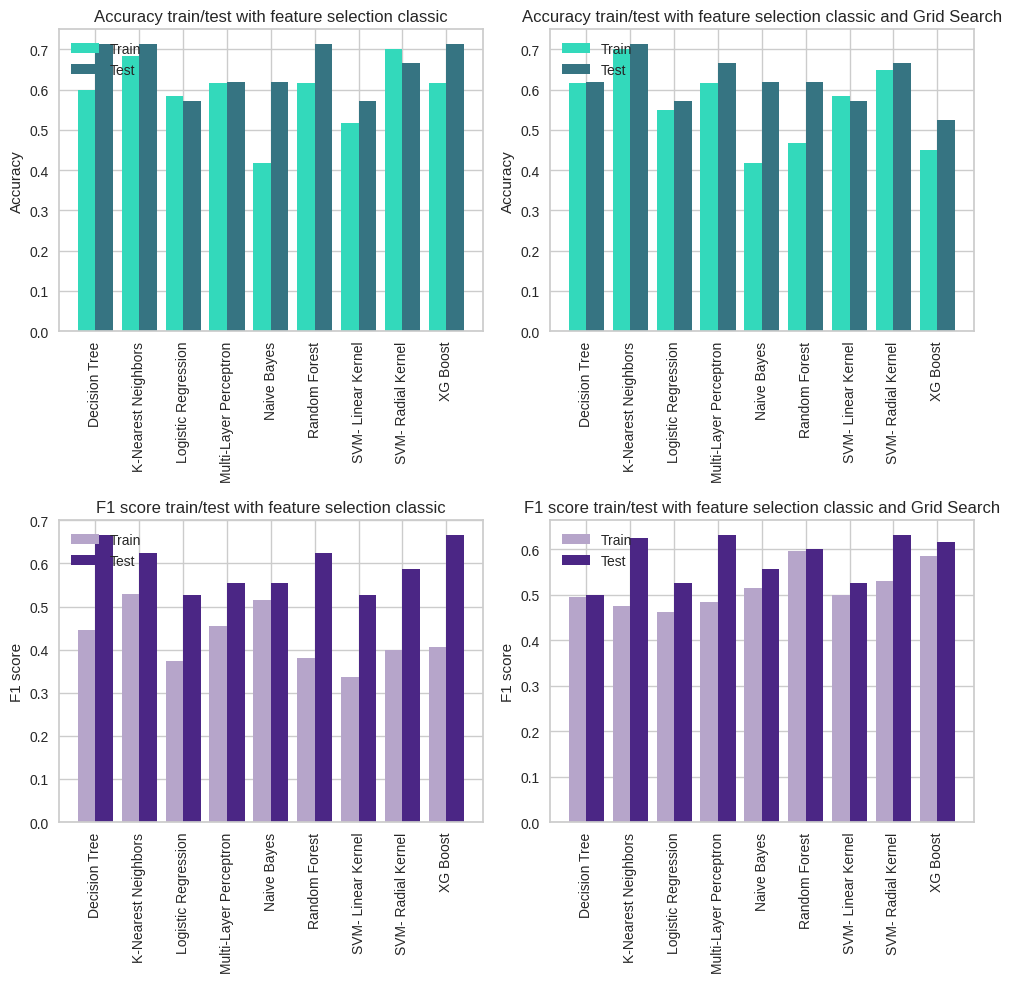

---------------------------------------------------------------------------------------------



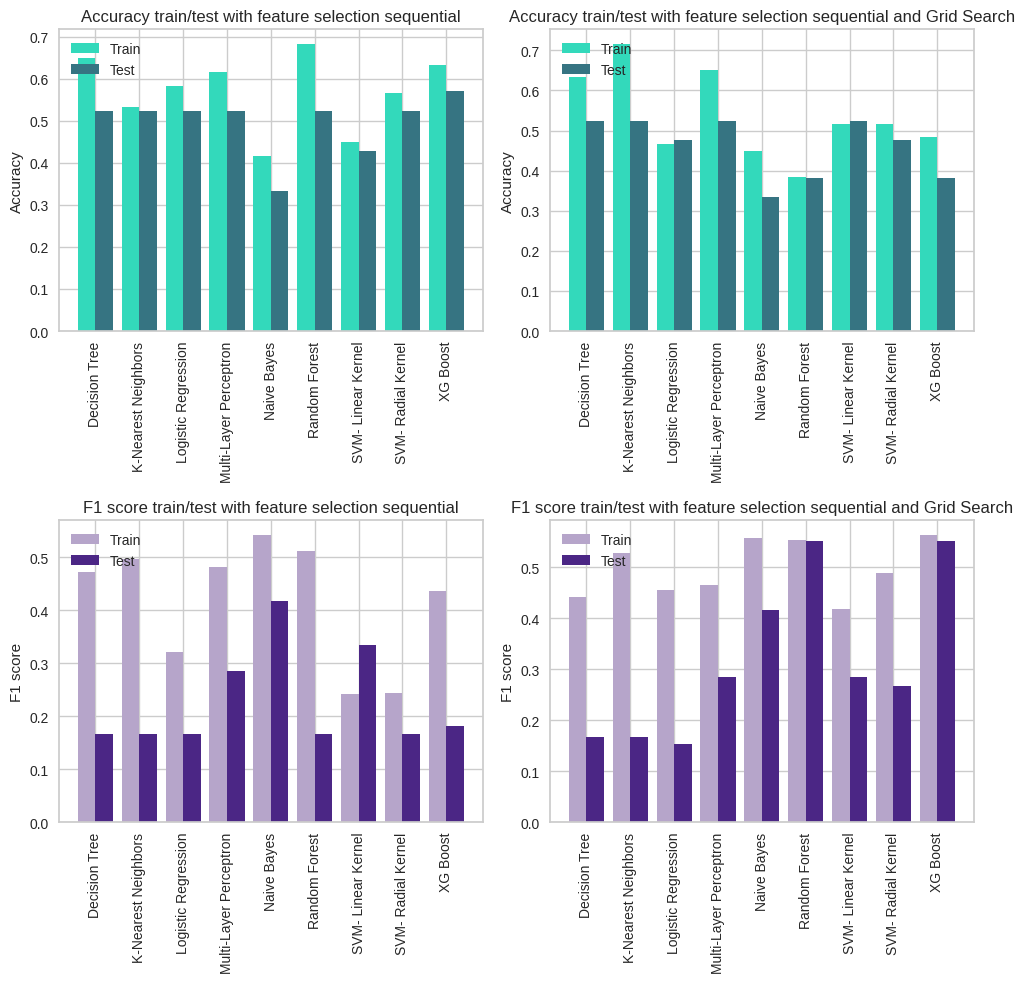

---------------------------------------------------------------------------------------------



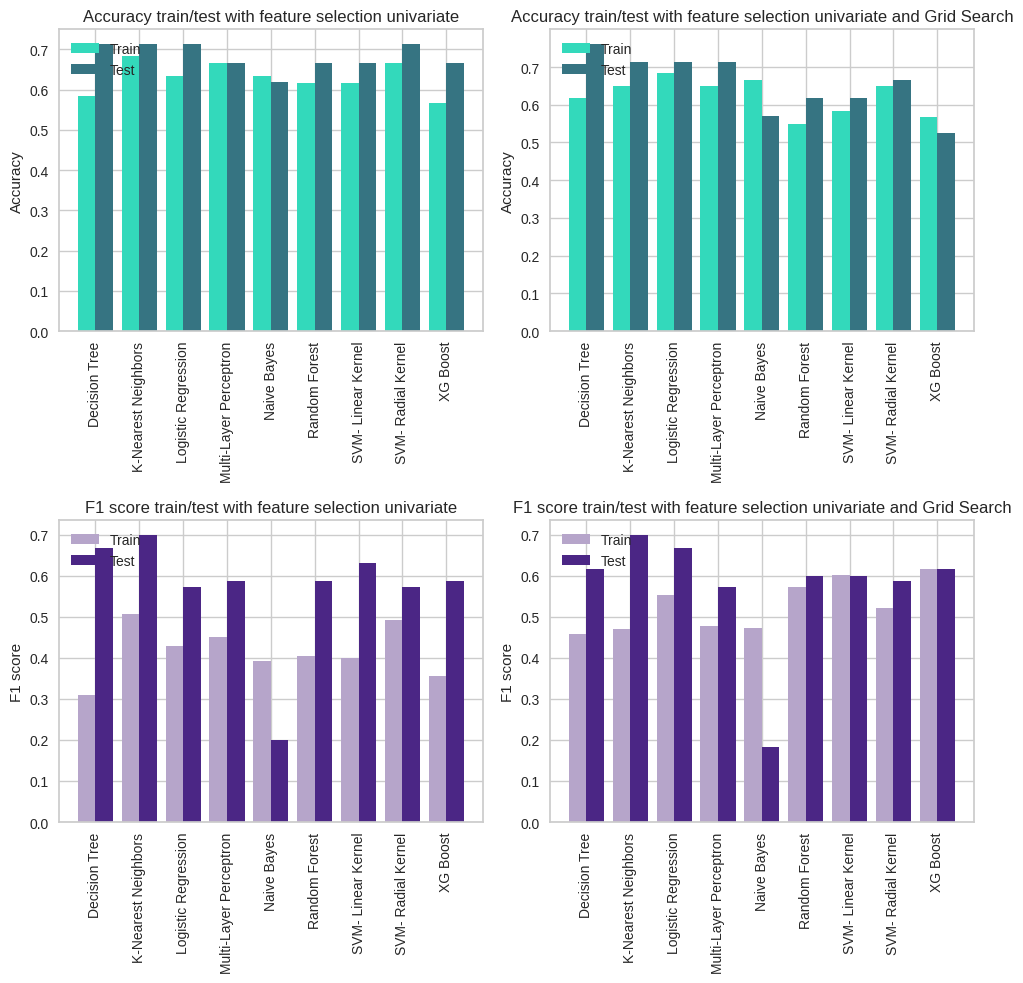

---------------------------------------------------------------------------------------------



In [ ]:
# Graficar los resultados obtenidos
methods=Resultados['Feature Selection'].unique()

for method in methods:
  df_filtrado = Resultados[(Resultados['Feature Selection'] == method)]
  metrics(df_filtrado, method)
  print('---------------------------------------------------------------------------------------------\n')

**Conclusiones**

Al comparar el F1-score de cada modelo según el método de selección de características, se observa que el método secuencial presenta el peor rendimiento en la mayoría de los modelos, excepto en el caso de Naive Bayes, donde el método univariado muestra el F1-score más bajo. Se recomienda utilizar el método clásico como técnica de selección de características en el modelo para determinar el credit score. Esta elección permitirá reducir la dimensionalidad del conjunto de datos y evitar problemas asociados con la multicolinealidad, lo que puede mejorar el rendimiento general del modelo.

Al evaluar los mejores modelos según el F1-score en orden descendente, se destacan los siguientes: KNN, SVM, Multi-Layer Perceptron, Decision Tree y XG Boost. Aunque KNN sobresale como el modelo con las mejores métricas, es fundamental ejercer precaución al aplicarlo en bases de datos con características "High Dimensional Small Dataset".

En primera instancia, se sugiere mejorar el tamaño de la base de datos para determinar un modelo más adecuado. En caso de no ser factible, se recomienda optar por SVM con radial-kernel, ya que ha demostrado buenos resultados tanto en métricas como en la matriz de confusión. Cabe recordar que los falsos negativos son especialmente relevantes al evaluar el riesgo crediticio.



# Pipeline para el modelo seleccionado

Una vez definido que modelo utilizar, se crea una funcion llamada `Pipeline` para realizar todo el modelamiento utilizando PyCaret.

In [ ]:
def Pipeline(db,model, method,gs):
  '''Funcion para modelar utilizando pycaret
  db: Base de datos a modelar
  model (str): modelo a utilizar segun la abreviatura de la libreria PyCaret
  method(str): metodo de feature selection a utilizar (univariate, classic, sequential)
  gs: Optimizacion del modelo
  '''
  # Configurar el modelo con el metodo de selección de características especificado
  db_copy=db.copy()
  db_copy.columns=db_copy.columns.str.replace('[^a-zA-Z0-9_]', ' ', regex=True)
  model_setup = setup(data= db_copy, target='target', session_id=42, train_size= 0.75 , fold= 4,
                      feature_selection = True, feature_selection_method = method,
                      n_features_to_select= 0.4,  normalize= True, remove_multicollinearity=True, verbose= False)

  # Crear y entrenar el modelo
  model = create_model(model, fold=4, verbose=False)

  #Verificar si es necesario optimizar el modelo
  if gs:
    best_model=tune_model(model, fold=4, optimize='F1', verbose= False)
  else:
    best_model= model

  #evaluar el modelo (train)
  evaluate=evaluate_model(best_model)

  #Guardar los resultados de las metricas
  train_metrics = pull()
  acc_train = train_metrics['Accuracy']['Mean']
  F1_train = train_metrics['F1']['Mean']

  #evaluar el modelo (toma el conjunto de test)
  prediction=predict_model(best_model)

  #Guardar los resultados de las metricas
  test_metrics = pull()
  acc_test = test_metrics['Accuracy'][0]
  F1_test = test_metrics['F1'][0]

  #Resultados de las metricas de train/test
  print(f'Accuracy_train:{acc_train} \n Accuracy test: {acc_test} \n F1 score train: {F1_train} \n F1 score test: {F1_test}')

  #finalizar el modelo
  final_model=finalize_model(best_model)

  # guardar el modelo
  save_model(best_model, 'Model ML')

In [ ]:
Pipeline(data, 'rbfsvm', 'classic',True)